In [24]:



import os
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
import subprocess
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib,pickle
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# from rtCommon.fileClient import FileInterface
# import rtCommon.projectUtils as projUtils
# from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti


# argParser = argparse.ArgumentParser()
# argParser.add_argument('--config', '-c', default='sub001.ses1.toml', type=str, help='experiment file (.json or .toml)')
# args = argParser.parse_args()
from rtCommon.cfg_loading import mkdir,cfg_loading
config="sub001.ses1.toml"
cfg = cfg_loading(config)

sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/')
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  if __name__ == '__main__':


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub001.ses1.toml


In [37]:

subject,dataSource,roiloc,N=cfg.subjectName,"realtime","schaefer2018",31
# subject,dataSource,roiloc,N=sys.argv[1],sys.argv[2],sys.argv[3],int(sys.argv[4])

print("Running subject {}, with {} as a data source, {}, starting with {} ROIs".format(subject, dataSource, roiloc, N))


# dataSource depending, there are a number of keywords to fill in: 
# ses: which day of data collection
# run: which run number on that day (single digit)
# phase: 12, 34, or 56
# sub: subject number
if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = cfg.recognition_dir + "brain_run{run}.npy"
    metadata = cfg.recognition_dir + "behav_run{run}.csv"
    # funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    # metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    # anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"

workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
if roiloc == "schaefer2018":
    RESULT=np.empty((len(subjects_correctly_aligned),300))
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for roinum in range(1,301):
            result = np.load("{}/{}.npy".format(outloc, roinum))
            RESULT[ii,roinum-1]=result
            # RESULT = result if roinum == 1 else np.vstack((RESULT, result))
    RESULT = np.mean(RESULT,axis=0)
    print(f"RESULT.shape={RESULT.shape}")
    RESULTix = RESULT[:].argsort()[-N:]
    for idx in RESULTix:
        topN.append("{}.nii.gz".format(idx+1))
        # print(topN[-1])


Running subject sub001, with realtime as a data source, schaefer2018, starting with 31 ROIs
RESULT.shape=(300,)


In [14]:
# # visualize the unified ROI rank for all subject for 31 ROIs, the orange point

# subject = "1206162"
# sub=subject
# workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
# di = load_obj(f"{workingDir}kp_scratch/tmp_folder/{subject}_{N}_{'schaefer2018_neurosketch'}_{31}")
# # GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
# bestROIs=di['bestROIs']
# bestROIs = [int(bestROI.split(".nii.gz")[0]) for bestROI in bestROIs]
# print(bestROIs)
# # # the brighter means the ROI was used in multiple subjects
# # import nibabel as nib
# # import pandas as pd

# # for pn, parc in enumerate(bestROIs):
# #     _mask = nib.load(workingDir+"/{}/{}/{}.nii.gz".format(roiloc, sub, parc))
# #     aff = _mask.affine
# #     _mask = _mask.get_data()
# #     _mask = _mask.astype(int)
# #     # say some things about the mask.
# #     mask = _mask if pn == 0 else mask + _mask
# #     # mask[mask>0] = 1
    
# # savemask = nib.Nifti1Image(mask, affine=aff)
# # nib.save(savemask, f"./top{31}mask.nii.gz")

# # # fslview_deprecated ./top31mask.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1206162/neurosketch_recognition_run_1_bet.nii.gz
# # # fslview_deprecated /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1206162/wanginfunc.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1206162/neurosketch_recognition_run_1_bet.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/top31mask.nii.gz



[236, 275, 213, 272, 33, 16, 92, 164, 17, 23, 223, 130, 80, 125, 262, 20, 37, 155, 91, 221, 36, 65, 171, 61, 176, 159, 105, 212, 107, 28, 78]


In [18]:

topN = load_obj(f"{cfg.recognition_expScripts_dir}top31ROIs")
print(f"len(topN)={len(topN)}")
print(f"topN={topN}")

def Wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))
        
def normalize(X):
    X = X - X.mean(3)
    return X

def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(8):
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[run])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
                
        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    
    return np.mean(accs)


len(topN)=31
topN=['236.nii.gz', '275.nii.gz', '213.nii.gz', '272.nii.gz', '33.nii.gz', '16.nii.gz', '92.nii.gz', '164.nii.gz', '17.nii.gz', '23.nii.gz', '223.nii.gz', '130.nii.gz', '80.nii.gz', '125.nii.gz', '262.nii.gz', '20.nii.gz', '37.nii.gz', '155.nii.gz', '91.nii.gz', '221.nii.gz', '36.nii.gz', '65.nii.gz', '171.nii.gz', '61.nii.gz', '176.nii.gz', '159.nii.gz', '105.nii.gz', '212.nii.gz', '107.nii.gz', '28.nii.gz', '78.nii.gz']


In [20]:

# phasedict = dict(zip([1,2,3,4,5,6,7,8],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}

In [26]:
def getMask(topN, cfg):
    for pn, parc in enumerate(topN):
        _mask = nib.load(cfg.recognition_dir+"mask/schaefer_{}".format(parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

mask=getMask(topN, cfg)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


In [28]:

print('mask dimensions: {}'. format(mask.shape))
print('number of voxels in mask: {}'.format(np.sum(mask)))

mask dimensions: (64, 64, 36)
number of voxels in mask: 2306


In [189]:
import pandas as pd
runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]
if len(actualRuns) < 8:
    runRecording_preDay = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/../runRecording.csv")
    actualRuns_preDay = list(runRecording_preDay['run'].iloc[list(np.where(1==1*(runRecording_preDay['type']=='recognition'))[0])])[-(8-len(actualRuns)):] # might be [5,6,7,8]
else: 
    actualRuns_preDay = []

assert len(actualRuns_preDay)+len(actualRuns)==8 

objects = ['bed', 'bench', 'chair', 'table']
brain_data=[]
behav_data=[]
for ii,run in enumerate(actualRuns): # load behavior and brain data for current session
    t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
    brain_data.append(t)

    t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
    t=list(t['Item'])
    behav_data.append(t)

for ii,run in enumerate(actualRuns_preDay): # load behavior and brain data for previous session
    t = np.load(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/brain_run{run}.npy")
    brain_data.append(t)

    t = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/behav_run{run}.csv")
    t=list(t['Item'])
    behav_data.append(t)


# FEAT=brain_data.reshape(brain_data.shape[0],-1)
# print(f"FEAT.shape={FEAT.shape}")
# FEAT_mean=np.mean(FEAT,axis=1)
# FEAT=(FEAT.T-FEAT_mean).T

# META=behav_data
save_obj([brain_data,behav_data],f"./tmp_folder/{subject}_{dataSource}_{roiloc}_{N}") #{len(topN)}_{i}


In [35]:
import os
os.chdir("/gpfs/milgram/pi/turk-browne/projects/rtSynth_rt/")
!pwd

/gpfs/milgram/pi/turk-browne/projects/rtSynth_rt


In [42]:
def wait(tmpFile):
    while not os.path.exists(tmpFile+'_result.npy'):
        time.sleep(5)
        print(f"waiting for {tmpFile}_result.npy\n")
    return np.load(tmpFile+'_result.npy')



In [179]:
!pwd

/gpfs/milgram/pi/turk-browne/projects/rtSynth_rt


In [167]:
brain_data = [t[:,mask==1] for t in brain_data]
# _runs = [runs[:,mask==1]]
print("Runs shape", [t.shape for t in brain_data])
slstart = time.time()


Runs shape [(47, 2482), (47, 2482), (48, 2482), (47, 2482), (47, 2482), (47, 2482), (48, 2482), (47, 2482)]


In [168]:
def Class(brain_data,behav_data):
    # metas = bcvar[0]
    # data4d = data[0]
    print([t.shape for t in brain_data])

    accs = []
    for run in range(8):
        testX = brain_data[run]
        testY = behav_data[run]

        trainX=np.zeros((1,1))
        for i in range(8):
            if i !=run:
                trainX=brain_data[i] if trainX.shape==(1,1) else np.concatenate((trainX,brain_data[i]),axis=0)

        trainY = []
        for i in range(8):
            if i != run:
                trainY.extend(behav_data[i])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
                
        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    
    return np.mean(accs)
# # sl_result = Class(behav_data,brain_data)
# from sklearn.linear_model import LogisticRegression
# print([t.shape for t in brain_data])

# accs = []
# for run in range(8):
#     testX = brain_data[run]
#     testY = behav_data[run]
    
#     trainX=np.zeros((1,1))
#     for i in range(8):
#         if i !=run:
#             trainX=brain_data[i] if trainX.shape==(1,1) else np.concatenate((trainX,brain_data[i]),axis=0)
            
# #     trainX = brain_data[np.arange(8) != run]
# #     trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
#     trainY = []
#     for i in range(8):
#         if i != run:
#             trainY.extend(behav_data[i])
# #             trainY = behav_data[i] if trainY.shape==(1,1) else pd.concat([trainY, behav_data[i]], ignore_index=True)

#     clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
#                              multi_class='multinomial').fit(trainX, trainY)

#     # Monitor progress by printing accuracy (only useful if you're running a test set)
#     acc = clf.score(testX, testY)
#     accs.append(acc)
sl_result = Class(brain_data,behav_data)


[(47, 2482), (47, 2482), (48, 2482), (47, 2482), (47, 2482), (47, 2482), (48, 2482), (47, 2482)]


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative 

In [173]:
save_obj({"subject":subject,
"startFromN":N,
"currNumberOfROI":len(topN),
"bestAcc":sl_result, # this is the sl_result for the topN, not the bestAcc, bestAcc is for the purpose of keeping consistent with others
"bestROIs":topN},# this is the topN, not the bestROIs, bestROIs is for the purpose of keeping consistent with others
f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}"
)


In [184]:
import itertools
import subprocess
from subprocess import call
# N-1
def numOfRunningJobs():
    # subprocess.Popen(['squeue -u kp578 | wc -l > squeue.txt'],shell=True) # sl_result = Class(_runs, bcvar)
    randomID=str(time.time())
    # print(f"squeue -u kp578 | wc -l > squeue/{randomID}.txt")
#     subprocess(f'squeue -u kp578 | wc -l > squeue/{randomID}.txt',shell=True)
    subprocess.Popen([f'squeue -u kp578 | wc -l > squeue/{randomID}.txt'],shell=True) # sl_result = Class(_runs, bcvar)
    numberOfJobsRunning = int(open(f"squeue/{randomID}.txt", "r").read())
    print(f"numberOfJobsRunning={numberOfJobsRunning}")
    return numberOfJobsRunning

print(f"len(topN)={len(topN)}")
print(f"topN={topN}")

allpairs = itertools.combinations(topN,len(topN)-1)
topNs=[]
sl_results=[]
tmpFiles=[]

for i,_topN in enumerate(allpairs):
    tmpFile=f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}_{i}"
    print(f"tmpFile={tmpFile}")
    topNs.append(_topN)
    tmpFiles.append(tmpFile)

    if not os.path.exists(tmpFile+'_result.npy'):
        # prepare brain data(runs) mask and behavior data(bcvar) 

        save_obj([_topN,subject,dataSource,roiloc,N], tmpFile)

        print("kp2")
#         numberOfJobsRunning = numOfRunningJobs()
#         print("kp3")
#         while numberOfJobsRunning > 400: # 300 is not filling it up
#             print("kp4 300")
#             print("waiting 10, too many jobs running") ; time.sleep(10)
#             numberOfJobsRunning = numOfRunningJobs()
#             print("kp5")

        # get the evidence for the current mask
        print(f'sbatch class.sh {tmpFile}')
        proc = subprocess.Popen([f'sbatch --requeue class.sh {tmpFile}'],shell=True) # sl_result = Class(_runs, bcvar) 
        print("kp6")
    else:
        print(tmpFile+'_result.npy exists!')
os.remove("./tmp_folder/holdon.npy")

# wait for everything to be finished and make a summary to find the best performed megaROI
sl_results=[]
for tmpFile in tmpFiles:
    sl_result=wait(tmpFile)
    sl_results.append(sl_result)
print(f"sl_results={sl_results}")
print(f"max(sl_results)=={max(sl_results)}")
maxID=np.where(sl_results==max(sl_results))[0][0]
save_obj({"subject":subject,
"startFromN":N,
"currNumberOfROI":len(topN)-1,
"bestAcc":max(sl_results),
"bestROIs":topNs[maxID]},
f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}"
)
print(f"bestAcc={max(sl_results)} For {len(topN)-1} = ./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}")
tmpFiles=next(topNs[maxID])


len(topN)=31
topN=['236.nii.gz', '275.nii.gz', '213.nii.gz', '272.nii.gz', '33.nii.gz', '16.nii.gz', '92.nii.gz', '164.nii.gz', '17.nii.gz', '23.nii.gz', '223.nii.gz', '130.nii.gz', '80.nii.gz', '125.nii.gz', '262.nii.gz', '20.nii.gz', '37.nii.gz', '155.nii.gz', '91.nii.gz', '221.nii.gz', '36.nii.gz', '65.nii.gz', '171.nii.gz', '61.nii.gz', '176.nii.gz', '159.nii.gz', '105.nii.gz', '212.nii.gz', '107.nii.gz', '28.nii.gz', '78.nii.gz']
tmpFile=./tmp_folder/sub001_31_schaefer2018_realtime_31_0
kp2
sbatch class.sh ./tmp_folder/sub001_31_schaefer2018_realtime_31_0
kp6
tmpFile=./tmp_folder/sub001_31_schaefer2018_realtime_31_1
kp2
sbatch class.sh ./tmp_folder/sub001_31_schaefer2018_realtime_31_1
kp6
tmpFile=./tmp_folder/sub001_31_schaefer2018_realtime_31_2
kp2
sbatch class.sh ./tmp_folder/sub001_31_schaefer2018_realtime_31_2
kp6
tmpFile=./tmp_folder/sub001_31_schaefer2018_realtime_31_3
kp2
sbatch class.sh ./tmp_folder/sub001_31_schaefer2018_realtime_31_3
kp6
tmpFile=./tmp_folder/sub001_31_sc

KeyboardInterrupt: 

conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
tmpFile=./tmp_folder/sub001_31_schaefer2018_realtime_31_29


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (64, 64, 36)
number of voxels in mask: 2203
Runs shape [(47, 2203), (47, 2203), (48, 2203), (47, 2203), (47, 2203), (47, 2203), (48, 2203), (47, 2203)]
[(47, 2203), (47, 2203), (48, 2203), (47, 2203), (47, 2203), (47, 2203), (48, 2203), (47, 2203)]


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative 

sl_result=0.36491578014184395


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


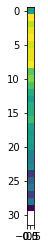

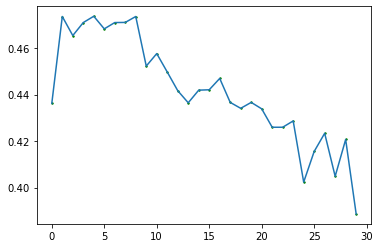

In [243]:
import os
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

roiloc="schaefer2018"
dataSource="realtime"
# subjects=glob("./wang2014/[0,1]*")
# subjects=[subject.split("/")[-1] for subject in subjects]
# subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
# subjects=subjects_correctly_aligned
subjects=['sub001']
N=31
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
for ii,subject in enumerate(subjects):
#     try:
#         GreedyBestAcc[ii,40]=np.load("./{}/{}/output/top{}.npy".format(roiloc, subject, N))
#     except:
#         pass

    for len_topN_1 in range(N-1,0,-1):
        # Wait(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # print(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        except:
            pass
GreedyBestAcc=GreedyBestAcc.T

plt.imshow(GreedyBestAcc)
_=plt.figure()
for i in range(GreedyBestAcc.shape[0]):
    plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i],c='g',s=2)
plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))

In [255]:
def getMask(topN, cfg):
    for pn, parc in enumerate(topN):
        _mask = nib.load(cfg.recognition_dir+"mask/schaefer_{}".format(parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask
performance_mean = np.nanmean(GreedyBestAcc,axis=1)
bestID=np.where(performance_mean==max(performance_mean))[0][0]
bestID
di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID+1}")
mask = getMask(di['bestROIs'],cfg)

cfg.chosenMask = f"{cfg.subjects_dir}{cfg.subjectName}/ses1/recognition/chosenMask.npy"
np.save(cfg.chosenMask,mask)

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


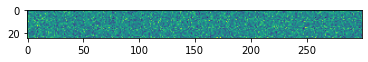

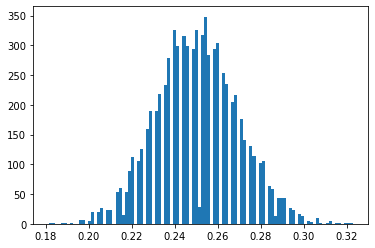

In [281]:
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
starttime = time.time()
# '1201161', '1121161','0115172','0112174' #these subject have nothing in output folder
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
roiloc = "schaefer2018"
if roiloc == "schaefer2018":
    RESULT=np.empty((len(subjects_correctly_aligned),300))
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for roinum in range(1,301):
            result = np.load("{}/{}.npy".format(outloc, roinum))
            RESULT[ii,roinum-1]=result
plt.imshow(RESULT)
a=RESULT.reshape(-1)
_=plt.figure()
_=plt.hist(a,bins=100)
            # RESULT = result if roinum == 1 else np.vstack((RESULT, result))
#     RESULT = np.mean(RESULT,axis=0)
#     print(f"RESULT.shape={RESULT.shape}")
#     RESULTix = RESULT[:].argsort()[-N:]
#     for idx in RESULTix:
#         topN.append("{}.nii.gz".format(idx+1))
#         print(topN[-1])


In [268]:

def minimalClass(cfg):
    '''
    purpose: 
        train offline models

    steps:
        load preprocessed and aligned behavior and brain data 
        select data with the wanted pattern like AB AC AD BC BD CD 
        train correspondng classifier and save the classifier performance and the classifiers themselves.

    '''

    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import sklearn
    import joblib
    import nibabel as nib
    import itertools
    from sklearn.linear_model import LogisticRegression

    def gaussian(x, mu, sig):
        # mu and sig is determined before each neurofeedback session using 2 recognition runs.
        return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

    def normalize(X):
        X = X - X.mean(0)
        return X

    def jitter(size,const=0):
        jit = np.random.normal(0+const, 0.05, size)
        X = np.zeros((size))
        X = X + jit
        return X

    def other(target):
        other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
        return other_objs

    def red_vox(n_vox, prop=0.1):
        return int(np.ceil(n_vox * prop))

    def get_inds(X, Y, pair, testRun=None):
        
        inds = {}
        
        # return relative indices
        if testRun:
            trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
        else:
            trainIX = Y.index[(Y['label'].isin(pair))]

        # pull training and test data
        trainX = X[trainIX]
        trainY = Y.iloc[trainIX].label
        
        # Main classifier on 5 runs, testing on 6th
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
        B = clf.coef_[0]  # pull betas

        # retrieve only the first object, then only the second object
        if testRun:
            obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
            obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
        else:
            obj1IX = Y.index[(Y['label'] == pair[0])]
            obj2IX = Y.index[(Y['label'] == pair[1])]

        # Get the average of the first object, then the second object
        obj1X = np.mean(X[obj1IX], 0)
        obj2X = np.mean(X[obj2IX], 0)

        # Build the importance map
        mult1X = obj1X * B
        mult2X = obj2X * B

        # Sort these so that they are from least to most important for a given category.
        sortmult1X = mult1X.argsort()[::-1]
        sortmult2X = mult2X.argsort()

        # add to a dictionary for later use
        inds[clf.classes_[0]] = sortmult1X
        inds[clf.classes_[1]] = sortmult2X
                 
        return inds

    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/'
    else:
        main_dir='/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/'

    working_dir=main_dir
    os.chdir(working_dir)

    '''
    if you read runRecording for current session and found that there are only 4 runs in the current session, 
    you read the runRecording for previous session and fetch the last 4 recognition runs from previous session
    '''
    runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
    actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]
    if len(actualRuns) < 8:
        runRecording_preDay = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/../runRecording.csv")
        actualRuns_preDay = list(runRecording_preDay['run'].iloc[list(np.where(1==1*(runRecording_preDay['type']=='recognition'))[0])])[-(8-len(actualRuns)):] # might be [5,6,7,8]
    else: 
        actualRuns_preDay = []

    assert len(actualRuns_preDay)+len(actualRuns)==8 

    objects = ['bed', 'bench', 'chair', 'table']

    for ii,run in enumerate(actualRuns): # load behavior and brain data for current session
        t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
        mask = np.load(f"{cfg.chosenMask}")
        t = t[:,mask==1]
        brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

        t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
        behav_data=t if ii==0 else pd.concat([behav_data,t])

    for ii,run in enumerate(actualRuns_preDay): # load behavior and brain data for previous session
        t = np.load(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/brain_run{run}.npy")
        mask = np.load(f"{cfg.chosenMask}")
        t = t[:,mask==1]
        brain_data = np.concatenate((brain_data,t), axis=0)

        t = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/behav_run{run}.csv")
        behav_data = pd.concat([behav_data,t])

    FEAT=brain_data.reshape(brain_data.shape[0],-1)
    print(f"FEAT.shape={FEAT.shape}")
    FEAT_mean=np.mean(FEAT,axis=1)
    FEAT=(FEAT.T-FEAT_mean).T

    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}
    label=[]
    for curr_trial in range(META.shape[0]):
        label.append(imcodeDict[META['Item'].iloc[curr_trial]])
    META['label']=label # merge the label column with the data dataframe

    # Which run to use as test data (leave as None to not have test data)
    testRun = 2 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

    # Decide on the proportion of crescent data to use for classification
    include = 1
    accuracyContainer=[]


    allpairs = itertools.combinations(objects,2)

    # Iterate over all the possible target pairs of objects
    for pair in allpairs:
        # Find the control (remaining) objects for this pair
        altpair = other(pair)
        
        # pull sorted indices for each of the critical objects, in order of importance (low to high)
        # inds = get_inds(FEAT, META, pair, testRun=testRun)
        
        # Find the number of voxels that will be left given your inclusion parameter above
        # nvox = red_vox(FEAT.shape[1], include)
        
        for obj in pair:
            # foil = [i for i in pair if i != obj][0]
            for altobj in altpair:
                
                # establish a naming convention where it is $TARGET_$CLASSIFICATION
                # Target is the NF pair (e.g. bed/bench)
                # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
                naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)
                
                # Pull the relevant inds from your previously established dictionary 
                # obj_inds = inds[obj]
                
                # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
                # if testRun:
                #     trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                #     testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
                # else:
                #     trainIX = META.index[(META['label'].isin([obj, altobj]))]
                #     testIX = META.index[(META['label'].isin([obj, altobj]))]
                # # pull training and test data
                # trainX = FEAT[trainIX]
                # testX = FEAT[testIX]
                # trainY = META.iloc[trainIX].label
                # testY = META.iloc[testIX].label
                
                # print(f"obj={obj},altobj={altobj}")
                # print(f"unique(trainY)={np.unique(trainY)}")
                # print(f"unique(testY)={np.unique(testY)}")
                # assert len(np.unique(trainY))==2

                if testRun:
                    trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
                    testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
                else:
                    trainIX = ((META['label']==obj) + (META['label']==altobj))
                    testIX = ((META['label']==obj) + (META['label']==altobj))
                # pull training and test data
                trainX = FEAT[trainIX]
                testX = FEAT[testIX]
                trainY = META.iloc[np.asarray(trainIX)].label
                testY = META.iloc[np.asarray(testIX)].label

                print(f"obj={obj},altobj={altobj}")
                print(f"unique(trainY)={np.unique(trainY)}")
                print(f"unique(testY)={np.unique(testY)}")
                assert len(np.unique(trainY))==2

                # # If you're selecting high-importance features, this bit handles that
                # if include < 1:
                #     trainX = trainX[:, obj_inds[-nvox:]]
                #     testX = testX[:, obj_inds[-nvox:]]
                
                # Train your classifier
                clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                         multi_class='multinomial').fit(trainX, trainY)
                
                model_folder = cfg.trainingModel_dir
                # Save it for later use
                joblib.dump(clf, model_folder +'/{}.joblib'.format(naming))
                
                # Monitor progress by printing accuracy (only useful if you're running a test set)
                acc = clf.score(testX, testY)
                print(naming, acc)
minimalClass(cfg)

FEAT.shape=(378, 439)
obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedbench_bedchair 0.875
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedbench_bedtable 0.5
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedbench_benchchair 0.7391304347826086
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedbench_benchtable 0.8695652173913043
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_bedbench 0.9565217391304348
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_bedtable 0.5
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_chairbench 0.7391304347826086
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_chairtable 0.75
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedtable_bedbench 0.9565217391304348
obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedtable_bedchair 0.875
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedtable_tablebench 0.8695652173913043
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedtable_tablechair 0.75
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchchair_benchbed 0.9565217391304348
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchchair_benchtable 0.8695652173913043
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchchair_chairbed 0.875
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchchair_chairtable 0.75
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_benchbed 0.9565217391304348
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_benchchair 0.7391304347826086
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_tablebed 0.5
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_tablechair 0.75
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

chairtable_chairbed 0.875
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

chairtable_chairbench 0.7391304347826086
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

chairtable_tablebed 0.5
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
chairtable_tablebench 0.8695652173913043


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [309]:
config="sub001.ses3.toml"
cfg = cfg_loading(config)
import pickle5 as pickle
import os
import numpy as np
import pandas as pd
import joblib
import nibabel as nib



if 'milgram' in os.getcwd():
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/'
else:
    main_dir='/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/'

working_dir=main_dir
os.chdir(working_dir)

runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]

objects = ['bed', 'bench', 'chair', 'table']

for ii,run in enumerate(actualRuns[:2]): # load behavior and brain data for current session
    t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
    # mask = nib.load(f"{cfg.chosenMask}").get_data()
    cfg.chosenMask = f"{cfg.subjects_dir}{cfg.subjectName}/ses1/recognition/chosenMask.npy"
    mask = np.load(cfg.chosenMask)
    t = t[:,mask==1]
    brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

    t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
    behav_data=t if ii==0 else pd.concat([behav_data,t])

FEAT=brain_data.reshape(brain_data.shape[0],-1)
FEAT_mean=np.mean(FEAT,axis=1)
FEAT=(FEAT.T-FEAT_mean).T
META=behav_data

# convert item colume to label colume
imcodeDict={
'A': 'bed',
'B': 'chair',
'C': 'table',
'D': 'bench'}
label=[]
for curr_trial in range(META.shape[0]):
    label.append(imcodeDict[META['Item'].iloc[curr_trial]])
META['label']=label # merge the label column with the data dataframe


def classifierEvidence(clf,X,Y): # X shape is [trials,voxelNumber], Y is ['bed', 'bed'] for example # return a 1-d array of probability
    # This function get the data X and evidence object I want to know Y, and output the trained model evidence.
    targetID=[np.where((clf.classes_==i)==True)[0][0] for i in Y]
    Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
    return np.asarray(Evidence)

A_ID = (META['label']=='bed')
X = FEAT[A_ID]

# evidence_floor is C evidence for AC_CD BC_CD CD_CD classifier(can also be D evidence for CD classifier)
Y = ['table'] * X.shape[0]
CD_clf=joblib.load(cfg.usingModel_dir +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
print(f"X.shape={X.shape}")
print(f"len(Y)={len(Y)}")
print(f"CD_clf.coef_.shape={CD_clf.coef_.shape}")
CD_C_evidence = classifierEvidence(CD_clf,X,Y)
evidence_floor = np.mean(CD_C_evidence)
print(f"evidence_floor={evidence_floor}")



# evidence_ceil  is A evidence in AC and AD classifier
Y = ['bed'] * X.shape[0]
AC_clf=joblib.load(cfg.usingModel_dir +'bedbench_bedtable.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
AC_A_evidence = classifierEvidence(AC_clf,X,Y)
evidence_ceil1 = AC_A_evidence

Y = ['bed'] * X.shape[0]
AD_clf=joblib.load(cfg.usingModel_dir +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
AD_A_evidence = classifierEvidence(AD_clf,X,Y)
evidence_ceil2 = AD_A_evidence

evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
print(f"evidence_ceil={evidence_ceil}")

toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub001.ses3.toml
X.shape=(24, 439)
len(Y)=24
CD_clf.coef_.shape=(1, 439)
evidence_floor=28.757000158484942
evidence_ceil=48.92288513658635


In [332]:
config="sub001.ses2.toml"
cfg = cfg_loading(config)
cfg.chosenMask = f"{cfg.subjects_dir}{cfg.subjectName}/ses1/recognition/chosenMask.npy"

def morphingTarget(cfg):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import joblib
    import nibabel as nib



    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/'
    else:
        main_dir='/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/'

    working_dir=main_dir
    os.chdir(working_dir)

    runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
    actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]

    objects = ['bed', 'bench', 'chair', 'table']

    for ii,run in enumerate(actualRuns[:2]): # load behavior and brain data for current session
        t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
        # mask = nib.load(f"{cfg.chosenMask}").get_data()
        mask = np.load(cfg.chosenMask)
        t = t[:,mask==1]
        brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

        t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
        behav_data=t if ii==0 else pd.concat([behav_data,t])

    FEAT=brain_data.reshape(brain_data.shape[0],-1)
    FEAT_mean=np.mean(FEAT,axis=0)
    FEAT=FEAT-FEAT_mean
    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}
    label=[]
    for curr_trial in range(META.shape[0]):
        label.append(imcodeDict[META['Item'].iloc[curr_trial]])
    META['label']=label # merge the label column with the data dataframe


    def classifierEvidence(clf,X,Y): # X shape is [trials,voxelNumber], Y is ['bed', 'bed'] for example # return a 1-d array of probability
        # This function get the data X and evidence object I want to know Y, and output the trained model evidence.
        targetID=[np.where((clf.classes_==i)==True)[0][0] for i in Y]
        Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
        return np.asarray(Evidence)

    A_ID = (META['label']=='bed')
    X = FEAT[A_ID]

    # evidence_floor is C evidence for AC_CD BC_CD CD_CD classifier(can also be D evidence for CD classifier)
    Y = ['table'] * X.shape[0]
    CD_clf=joblib.load(cfg.usingModel_dir +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    evidence_floor = np.mean(CD_C_evidence)
    print(f"evidence_floor={evidence_floor}")

    # evidence_ceil  is A evidence in AC and AD classifier
    Y = ['bed'] * X.shape[0]
    AC_clf=joblib.load(cfg.usingModel_dir +'bedbench_bedtable.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_A_evidence = classifierEvidence(AC_clf,X,Y)
    evidence_ceil1 = AC_A_evidence

    Y = ['bed'] * X.shape[0]
    AD_clf=joblib.load(cfg.usingModel_dir +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_A_evidence = classifierEvidence(AD_clf,X,Y)
    evidence_ceil2 = AD_A_evidence

    evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    print(f"evidence_ceil={evidence_ceil}")

    return evidence_floor, evidence_ceil
morphingTarget(cfg)

toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub001.ses2.toml
evidence_floor=2.763149615387828
evidence_ceil=1.9822546383128437


(2.763149615387828, 1.9822546383128437)

In [355]:
FEAT-FEAT.mean(0)

array([[ 18.8223954 ,  -3.83023618,  19.56976382, ...,  18.89607961,
        -13.8407625 ,  16.43292171],
       [ 18.08435439,   4.43172282,  31.83172282, ...,  20.1580386 ,
          8.4211965 ,  20.69488071],
       [ 31.50121089,   8.84857931,  53.24857931, ...,  13.5748951 ,
          8.83805299,  18.1117372 ],
       ...,
       [-11.64229709,  18.70507133, -16.89492867, ...,  12.43138712,
         -1.30545498,   4.96822923],
       [-17.89058866,  15.45677976, -31.14322024, ..., -17.81690445,
        -13.55374655,   8.71993766],
       [-24.04548615,   4.30188227, -32.29811773, ..., -20.97180194,
        -12.70864405,  11.56504016]])

In [293]:


import os
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
import subprocess
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
# from rtCommon.fileClient import FileInterface
# import rtCommon.projectUtils as projUtils
# from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti


# argParser = argparse.ArgumentParser()
# argParser.add_argument('--config', '-c', default='sub001.ses1.toml', type=str, help='experiment file (.json or .toml)')
# args = argParser.parse_args()
from rtCommon.cfg_loading import mkdir,cfg_loading
config="sub001.ses2.toml"
cfg = cfg_loading(config)

sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/')
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading
def wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))

'''
convert all dicom files into nii files in the temp dir. 
find the middle volume of the run1 as the template volume
align every other functional volume with templateFunctionalVolume (3dvolreg)
'''
recognition_preprocess(cfg) #somehow this cannot be run in jupyter


'''
run the mask selection
    make ROIs
        make-schaefer-rois.sh
    starting from 31 megaROIs use greedyMask to find best ROI for the current subject
'''
# make ROIs
if cfg.session==1:
    subprocess.Popen(f"sbatch {cfg.recognition_expScripts_dir}make-schaefer-rois.sh {cfg.subjectName} {cfg.recognition_dir}",shell=True)
    wait(f"{cfg.recognition_dir}mask/schaefer_300.nii.gz")

    # when this is the first session, you need to select the chosenMask
    # python expScripts/recognition/greedyMask.py
    greedyMask(config)

# train the classifiers
minimalClass(cfg)

toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub001.ses2.toml
running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses2/recognition/run1.nii  /tmp/1613519908.7020886/001_000001_000001_aligned.nii /tmp/1613519908.7020886/001_000001_000002_aligned.nii /tmp/1613519908.7020886/001_000001_000003_aligned.nii /tmp/1613519908.7020886/001_000001_000004_aligned.nii /tmp/1613519908.7020886/001_000001_000005_aligned.nii /tmp/1613519908.7020886/001_000001_000006_aligned.nii /tmp/1613519908.7020886/001_000001_000007_aligned.nii /tmp/1613519908.7020886/001_000001_000008_aligned.nii /tmp/1613519908.7020886/001_000001_000009_aligned.nii /tmp/1613519908.7020886/001_000001_000010_aligned.nii /tmp/1613519908.7020886/001_000001_000011_aligned.nii /tmp/1613519908.7020886/001_000001_000012_aligned.nii /tmp/1613519908.7020886/001_000001_000013_aligned.nii /tmp/1613519908.7020886/001_000001_000014_aligned.nii /tmp/1613519908.7

running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses2/recognition/run2.nii  /tmp/1613519908.7020886/001_000002_000001_aligned.nii /tmp/1613519908.7020886/001_000002_000002_aligned.nii /tmp/1613519908.7020886/001_000002_000003_aligned.nii /tmp/1613519908.7020886/001_000002_000004_aligned.nii /tmp/1613519908.7020886/001_000002_000005_aligned.nii /tmp/1613519908.7020886/001_000002_000006_aligned.nii /tmp/1613519908.7020886/001_000002_000007_aligned.nii /tmp/1613519908.7020886/001_000002_000008_aligned.nii /tmp/1613519908.7020886/001_000002_000009_aligned.nii /tmp/1613519908.7020886/001_000002_000010_aligned.nii /tmp/1613519908.7020886/001_000002_000011_aligned.nii /tmp/1613519908.7020886/001_000002_000012_aligned.nii /tmp/1613519908.7020886/001_000002_000013_aligned.nii /tmp/1613519908.7020886/001_000002_000014_aligned.nii /tmp/1613519908.7020886/001_000002_000015_aligned.nii /tmp/1613519908.7020886/001_000002_000016_aligned.nii /tmp/1613519908.702

running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses2/recognition/run3.nii  /tmp/1613519908.7020886/001_000003_000001_aligned.nii /tmp/1613519908.7020886/001_000003_000002_aligned.nii /tmp/1613519908.7020886/001_000003_000003_aligned.nii /tmp/1613519908.7020886/001_000003_000004_aligned.nii /tmp/1613519908.7020886/001_000003_000005_aligned.nii /tmp/1613519908.7020886/001_000003_000006_aligned.nii /tmp/1613519908.7020886/001_000003_000007_aligned.nii /tmp/1613519908.7020886/001_000003_000008_aligned.nii /tmp/1613519908.7020886/001_000003_000009_aligned.nii /tmp/1613519908.7020886/001_000003_000010_aligned.nii /tmp/1613519908.7020886/001_000003_000011_aligned.nii /tmp/1613519908.7020886/001_000003_000012_aligned.nii /tmp/1613519908.7020886/001_000003_000013_aligned.nii /tmp/1613519908.7020886/001_000003_000014_aligned.nii /tmp/1613519908.7020886/001_000003_000015_aligned.nii /tmp/1613519908.7020886/001_000003_000016_aligned.nii /tmp/1613519908.702

running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses2/recognition/run4.nii  /tmp/1613519908.7020886/001_000004_000001_aligned.nii /tmp/1613519908.7020886/001_000004_000002_aligned.nii /tmp/1613519908.7020886/001_000004_000003_aligned.nii /tmp/1613519908.7020886/001_000004_000004_aligned.nii /tmp/1613519908.7020886/001_000004_000005_aligned.nii /tmp/1613519908.7020886/001_000004_000006_aligned.nii /tmp/1613519908.7020886/001_000004_000007_aligned.nii /tmp/1613519908.7020886/001_000004_000008_aligned.nii /tmp/1613519908.7020886/001_000004_000009_aligned.nii /tmp/1613519908.7020886/001_000004_000010_aligned.nii /tmp/1613519908.7020886/001_000004_000011_aligned.nii /tmp/1613519908.7020886/001_000004_000012_aligned.nii /tmp/1613519908.7020886/001_000004_000013_aligned.nii /tmp/1613519908.7020886/001_000004_000014_aligned.nii /tmp/1613519908.7020886/001_000004_000015_aligned.nii /tmp/1613519908.7020886/001_000004_000016_aligned.nii /tmp/1613519908.702

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedbench_bedchair 0.7916666666666666
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedbench_bedtable 0.5833333333333334
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedbench_benchchair 0.625
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
bedbench_benchtable 0.7083333333333334
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedchair_bedbench 0.75
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_bedtable 0.5833333333333334
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_chairbench 0.625
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_chairtable 0.8333333333333334
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedtable_bedbench 0.75
obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']
bedtable_bedchair 0.7916666666666666
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedtable_tablebench 0.7083333333333334
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedtable_tablechair 0.8333333333333334
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchchair_benchbed 0.75
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
benchchair_benchtable 0.7083333333333334
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchchair_chairbed 0.7916666666666666
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchchair_chairtable 0.8333333333333334
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_benchbed 0.75
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_benchchair 0.625
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_tablebed 0.5833333333333334
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_tablechair 0.8333333333333334
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']
chairtable_chairbed 0.7916666666666666
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

chairtable_chairbench 0.625
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

chairtable_tablebed 0.5833333333333334
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
chairtable_tablebench 0.7083333333333334


In [304]:


def minimalClass(cfg):
    '''
    purpose: 
        train offline models

    steps:
        load preprocessed and aligned behavior and brain data 
        select data with the wanted pattern like AB AC AD BC BD CD 
        train correspondng classifier and save the classifier performance and the classifiers themselves.

    '''

    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import sklearn
    import joblib
    import nibabel as nib
    import itertools
    from sklearn.linear_model import LogisticRegression

    def gaussian(x, mu, sig):
        # mu and sig is determined before each neurofeedback session using 2 recognition runs.
        return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

    def normalize(X):
        X = X - X.mean(0)
        return X

    def jitter(size,const=0):
        jit = np.random.normal(0+const, 0.05, size)
        X = np.zeros((size))
        X = X + jit
        return X

    def other(target):
        other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
        return other_objs

    def red_vox(n_vox, prop=0.1):
        return int(np.ceil(n_vox * prop))

    def get_inds(X, Y, pair, testRun=None):
        
        inds = {}
        
        # return relative indices
        if testRun:
            trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
        else:
            trainIX = Y.index[(Y['label'].isin(pair))]

        # pull training and test data
        trainX = X[trainIX]
        trainY = Y.iloc[trainIX].label
        
        # Main classifier on 5 runs, testing on 6th
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
        B = clf.coef_[0]  # pull betas

        # retrieve only the first object, then only the second object
        if testRun:
            obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
            obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
        else:
            obj1IX = Y.index[(Y['label'] == pair[0])]
            obj2IX = Y.index[(Y['label'] == pair[1])]

        # Get the average of the first object, then the second object
        obj1X = np.mean(X[obj1IX], 0)
        obj2X = np.mean(X[obj2IX], 0)

        # Build the importance map
        mult1X = obj1X * B
        mult2X = obj2X * B

        # Sort these so that they are from least to most important for a given category.
        sortmult1X = mult1X.argsort()[::-1]
        sortmult2X = mult2X.argsort()

        # add to a dictionary for later use
        inds[clf.classes_[0]] = sortmult1X
        inds[clf.classes_[1]] = sortmult2X
                 
        return inds

    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/'
    else:
        main_dir='/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/'

    working_dir=main_dir
    os.chdir(working_dir)

    '''
    if you read runRecording for current session and found that there are only 4 runs in the current session, 
    you read the runRecording for previous session and fetch the last 4 recognition runs from previous session
    '''
    runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
    actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]
    if len(actualRuns) < 8:
        runRecording_preDay = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/../runRecording.csv")
        actualRuns_preDay = list(runRecording_preDay['run'].iloc[list(np.where(1==1*(runRecording_preDay['type']=='recognition'))[0])])[-(8-len(actualRuns)):] # might be [5,6,7,8]
    else: 
        actualRuns_preDay = []

    assert len(actualRuns_preDay)+len(actualRuns)==8 

    objects = ['bed', 'bench', 'chair', 'table']
    cfg.chosenMask = f"{cfg.subjects_dir}{cfg.subjectName}/ses1/recognition/chosenMask.npy"
    for ii,run in enumerate(actualRuns): # load behavior and brain data for current session
        t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
        
        mask = np.load(f"{cfg.chosenMask}")
        t = t[:,mask==1]
        brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

        t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
        behav_data=t if ii==0 else pd.concat([behav_data,t])

    for ii,run in enumerate(actualRuns_preDay): # load behavior and brain data for previous session
        t = np.load(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/brain_run{run}.npy")
        mask = np.load(f"{cfg.chosenMask}")
        t = t[:,mask==1]
        brain_data = np.concatenate((brain_data,t), axis=0)

        t = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/behav_run{run}.csv")
        behav_data = pd.concat([behav_data,t])

    FEAT=brain_data.reshape(brain_data.shape[0],-1)
    print(f"FEAT.shape={FEAT.shape}")
    FEAT_mean=np.mean(FEAT,axis=1)
    FEAT=(FEAT.T-FEAT_mean).T

    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}
    label=[]
    for curr_trial in range(META.shape[0]):
        label.append(imcodeDict[META['Item'].iloc[curr_trial]])
    META['label']=label # merge the label column with the data dataframe

    # Which run to use as test data (leave as None to not have test data)
    testRun = 2 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

    # Decide on the proportion of crescent data to use for classification
    include = 1
    accuracyContainer=[]


    allpairs = itertools.combinations(objects,2)

    # Iterate over all the possible target pairs of objects
    for pair in allpairs:
        # Find the control (remaining) objects for this pair
        altpair = other(pair)
        
        # pull sorted indices for each of the critical objects, in order of importance (low to high)
        # inds = get_inds(FEAT, META, pair, testRun=testRun)
        
        # Find the number of voxels that will be left given your inclusion parameter above
        # nvox = red_vox(FEAT.shape[1], include)
        
        for obj in pair:
            # foil = [i for i in pair if i != obj][0]
            for altobj in altpair:
                
                # establish a naming convention where it is $TARGET_$CLASSIFICATION
                # Target is the NF pair (e.g. bed/bench)
                # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
                naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)
                
                # Pull the relevant inds from your previously established dictionary 
                # obj_inds = inds[obj]
                
                # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
                # if testRun:
                #     trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                #     testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
                # else:
                #     trainIX = META.index[(META['label'].isin([obj, altobj]))]
                #     testIX = META.index[(META['label'].isin([obj, altobj]))]
                # # pull training and test data
                # trainX = FEAT[trainIX]
                # testX = FEAT[testIX]
                # trainY = META.iloc[trainIX].label
                # testY = META.iloc[testIX].label
                
                # print(f"obj={obj},altobj={altobj}")
                # print(f"unique(trainY)={np.unique(trainY)}")
                # print(f"unique(testY)={np.unique(testY)}")
                # assert len(np.unique(trainY))==2

                if testRun:
                    trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
                    testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
                else:
                    trainIX = ((META['label']==obj) + (META['label']==altobj))
                    testIX = ((META['label']==obj) + (META['label']==altobj))
                # pull training and test data
                trainX = FEAT[trainIX]
                testX = FEAT[testIX]
                trainY = META.iloc[np.asarray(trainIX)].label
                testY = META.iloc[np.asarray(testIX)].label

                print(f"obj={obj},altobj={altobj}")
                print(f"unique(trainY)={np.unique(trainY)}")
                print(f"unique(testY)={np.unique(testY)}")
                assert len(np.unique(trainY))==2

                # # If you're selecting high-importance features, this bit handles that
                # if include < 1:
                #     trainX = trainX[:, obj_inds[-nvox:]]
                #     testX = testX[:, obj_inds[-nvox:]]
                
                # Train your classifier
                clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                         multi_class='multinomial').fit(trainX, trainY)
                
                model_folder = cfg.trainingModel_dir
                # Save it for later use
                joblib.dump(clf, model_folder +'/{}.joblib'.format(naming))
                
                # Monitor progress by printing accuracy (only useful if you're running a test set)
                acc = clf.score(testX, testY)
                print(naming, acc)

                
config="sub001.ses2.toml"
cfg = cfg_loading(config)

# train the classifiers
minimalClass(cfg)

toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub001.ses2.toml
FEAT.shape=(380, 439)
obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedbench_bedchair 0.9166666666666666
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedbench_bedtable 0.5416666666666666
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedbench_benchchair 0.5416666666666666
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedbench_benchtable 0.6666666666666666
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_bedbench 0.5833333333333334
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_bedtable 0.5416666666666666
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_chairbench 0.5416666666666666
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_chairtable 0.6666666666666666
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedtable_bedbench 0.5833333333333334
obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedtable_bedchair 0.9166666666666666
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedtable_tablebench 0.6666666666666666
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedtable_tablechair 0.6666666666666666
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchchair_benchbed 0.5833333333333334
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchchair_benchtable 0.6666666666666666
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchchair_chairbed 0.9166666666666666
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchchair_chairtable 0.6666666666666666
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_benchbed 0.5833333333333334
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_benchchair 0.5416666666666666
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_tablebed 0.5416666666666666
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_tablechair 0.6666666666666666
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

chairtable_chairbed 0.9166666666666666
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

chairtable_chairbench 0.5416666666666666
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

chairtable_tablebed 0.5416666666666666
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
chairtable_tablebench 0.6666666666666666


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 1.0, 'bestID=25')

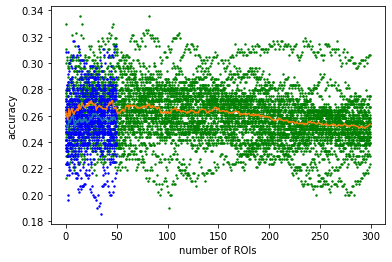

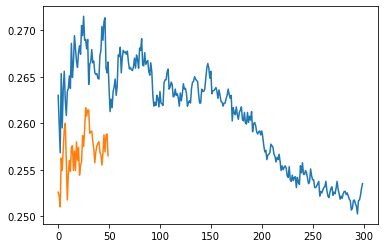

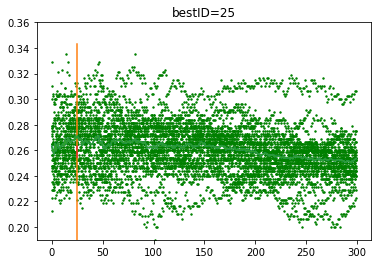

In [1]:
from glob import glob
import numpy as np
# di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"
# subs=glob(f"{di}[0,1]*_neurosketch")
# subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
# subjects=""
# for sub in subs:
#     subjects=subjects+sub+" "


testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subs=subjects_correctly_aligned
subjects=subs #["0110171", "0110172", "0111171"]
hemis=["lh", "rh"]

wangAcc=np.zeros((50,len(subs)))
roiloc="wang2014"
for sub_i,sub in enumerate(subjects):
    for num in range(1,51):
        # try:
        wangAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/uniMaskRank_top{num}.npy")
        # print(f"{roiloc} {sub} {num} ROIs acc={wangAcc[num-1,sub_i]}")
        # except:
        #     pass

schaeferAcc=np.zeros((300,len(subs)))
roiloc="schaefer2018"
for sub_i,sub in enumerate(subjects):
    for num in range(1,301):
        # try:
        schaeferAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/uniMaskRank_top{num}.npy")
        # print(f"{roiloc} {sub} {num} ROIs acc={schaeferAcc[num-1,sub_i]}")
        # except:
        #     pass


wangAcc=wangAcc[:,wangAcc[0]!=0]
schaeferAcc=schaeferAcc[:,schaeferAcc[0]!=0]
schaeferAcc[schaeferAcc==0]=None

import matplotlib.pyplot as plt
plt.plot(np.nanmean(wangAcc,axis=1))
plt.plot(np.nanmean(schaeferAcc,axis=1))


for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i],c='b',s=2)

plt.xlabel("number of ROIs")
plt.ylabel("accuracy")
# plt.savefig('SummaryAccuracy.png')


plt.figure()
plt.plot(np.mean(schaeferAcc,axis=1))
plt.plot(np.mean(wangAcc,axis=1))


schaeferAcc_mean=np.mean(schaeferAcc,axis=1)
bestID=np.where(schaeferAcc_mean==np.nanmax(schaeferAcc_mean))[0][0]
_=plt.figure()
for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
plt.plot(np.arange(schaeferAcc.shape[0]),np.nanmean(schaeferAcc,axis=1))
plt.ylim([0.19,0.36])
plt.plot([bestID]*10,np.arange(0.19,0.36,(0.36-0.19)/10))


plt.plot(np.arange(schaeferAcc.shape[0]),np.nanmean(schaeferAcc,axis=1))
plt.plot([bestID]*10,np.arange(0.255,0.264,(0.264-0.255)/10))
plt.title(f"bestID={bestID}")


In [9]:
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
import subprocess
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib,pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
!pwd

# visualize the unified ROI rank for all subject for 31 ROIs, the orange point

subject = "1206162"
sub=subject
di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{26}")
# GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
bestROIs=di['bestROIs']
bestROIs = [int(bestROI.split(".nii.gz")[0]) for bestROI in bestROIs]
print(bestROIs)
# the brighter means the ROI was used in multiple subjects
import nibabel as nib
import pandas as pd
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
for pn, parc in enumerate(bestROIs):
    _mask = nib.load(workingDir+"/{}/{}/{}.nii.gz".format(roiloc, sub, parc))
    aff = _mask.affine
    _mask = _mask.get_data()
    _mask = _mask.astype(int)
    # say some things about the mask.
    mask = _mask if pn == 0 else mask + _mask
    # mask[mask>0] = 1
    
savemask = nib.Nifti1Image(mask, affine=aff)
nib.save(savemask, f"./top{26}mask.nii.gz")

# fslview_deprecated ./top31mask.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1206162/neurosketch_recognition_run_1_bet.nii.gz
# fslview_deprecated /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1206162/wanginfunc.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1206162/neurosketch_recognition_run_1_bet.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/top31mask.nii.gz



/gpfs/milgram/pi/turk-browne/projects/rtTest/kp_scratch


NameError: name 'N' is not defined

In [76]:
'''
purpose:
    according to the given number of ROIs N, pick up the top N ROIs accuracy and combine them for a combined mask and retrain the model and getting result

steps:
    load accuracy for all the ROIs for given subject
    pick up the top N ROIs
    combine these top N masks
    retrain the model and get the accuracy.

steps modified for a unified mask rank for all subjects: uniMaskRank_
    load accuracy for all the ROIs for all subjects
    for each ROI, average the performance from each subject and get a single number for each ROI
    pick up the top N ROIs
    combine these top N masks
    retrain the model and get the accuracy.

'''
'''
you could try to see whether combining parcels improves performance. 
That's going to be the most important bit, because we'll want to decide on a tradeoff between number of voxels and accuracy. 
The script of interest here is aggregate.sh which is just a feeder for aggregate.py. 
This will use the .npy outputs of classRegion.py to select and merge the top N ROIs/parcels, and will return the list of ROI names, the number of voxels, and the cross-validated classifier accuracy 
in this newly combined larger mask. An example run of this is as follows:
sbatch aggregate.sh 0111171 neurosketch schaefer2018 15
'''
import numpy as np
import nibabel as nib
import os
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression

# What subject are you running
'''
Takes args (in order):
    subject (e.g. 0111171)
    dataSource (e.g. neurosketch, but also realtime)
    roiloc (wang2014 or schaefer2018)
    N (the number of parcels or ROIs to start with)
'''
subject = "1130161"
N = 157

try:
    roiloc = "schaefer2018"
    print("Using user-selected roi location: {}".format(roiloc))
except:
    print("NO ROI LOCATION ENTERED: Using roi location of wang2014")
    roiloc = "wang2014"

try:
    dataSource = "neurosketch"  # could be neurosketch or realtime
    print("Using {} data".format(dataSource))
except:
    print("NO DATASOURCE ENTERED: Using original neurosketch data")
    dataSource = 'neurosketch'

print("Running subject {}, with {} as a data source, {}, starting with {} ROIs".format(subject, dataSource, roiloc, N))


# dataSource depending, there are a number of keywords to fill in: 
# ses: which day of data collection
# run: which run number on that day (single digit)
# phase: 12, 34, or 56
# sub: subject number
if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"

workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
starttime = time.time()
# '1201161', '1121161','0115172','0112174' #these subject have nothing in output folder
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
if roiloc == "schaefer2018":
    RESULT=np.empty((len(subjects_correctly_aligned),300))
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for roinum in range(1,301):
            result = np.load("{}/{}.npy".format(outloc, roinum))
            RESULT[ii,roinum-1]=result
            # RESULT = result if roinum == 1 else np.vstack((RESULT, result))
    RESULT = np.mean(RESULT,axis=0)
    print(f"RESULT.shape={RESULT.shape}")
    RESULTix = RESULT[:].argsort()[-N:]
    for idx in RESULTix:
        topN.append("{}.nii.gz".format(idx+1))
        print(topN[-1])
else:
    RESULT_all=[]
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for hemi in ["lh", "rh"]:
            for roinum in range(1, 26):
                result = np.load("{}/roi{}_{}.npy".format(outloc, roinum, hemi))
                Result = result if roinum == 1 else np.vstack((Result, result))
            RESULT = Result if hemi == "lh" else np.hstack((RESULT, Result))
        RESULT_all.append(RESULT)

    RESULT_all=np.asarray(RESULT_all)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT_all=np.mean(RESULT_all,axis=0)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT1d = RESULT.flatten()
    RESULTix = RESULT1d.argsort()[-N:]
    x_idx, y_idx = np.unravel_index(RESULTix, RESULT.shape)

    # Check that we got the largest values.
    for x, y, in zip(x_idx, y_idx):
        print(x,y)
        if y == 0:
            topN.append("roi{}_lh.nii.gz".format(x+1))
        else:
            topN.append("roi{}_rh.nii.gz".format(x+1))
        print(topN[-1])


def Wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))
        
def normalize(X):
    from scipy.stats import zscore
    # X = X - X.mean(0)
    X = zscore(X, axis=0, nan_policy='omit')
    return X


def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[meta])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
                
        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    
    return np.mean(accs)


phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}

for pn, parc in enumerate(topN):
    _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
    aff = _mask.affine
    _mask = _mask.get_data()
    _mask = _mask.astype(int)
    # say some things about the mask.
    mask = _mask if pn == 0 else mask + _mask
    mask[mask>0] = 1
print('mask dimensions: {}'. format(mask.shape))
print('number of voxels in mask: {}'.format(np.sum(mask)))

# Compile preprocessed data and corresponding indices
metas = []

for run in range(1, 7):
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_data()
    print(f"np.sum(1*np.isnan(runImDat))={np.sum(1*np.isnan(runImDat))}")
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    features = features[:, mask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    print(f"np.sum(1*np.isnan(features))={np.sum(1*np.isnan(features))}")
    features = normalize(features)
    print(f"np.sum(1*np.isnan(features))={np.sum(1*np.isnan(features))}")
    features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    metas.append(labels)
    runs = features if run == 1 else np.concatenate((runs, features))

dimsize = runIm.header.get_zooms()

data = []
# Preset the variables
print("Runs shape", runs.shape)
_data = runs
print(_data.shape)
data.append(_data)
print("shape of data: {}".format(_data.shape))
    
bcvar = [metas]
                 
# Distribute the information to the searchlights (preparing it to run)
slstart = time.time()
sl_result = Class(data, bcvar)
print("results of classifier: {}, type: {}".format(sl_result, type(sl_result)))

SL = time.time() - slstart
tot = time.time() - starttime
print('total time: {}, searchlight time: {}'.format(tot, SL))



Using user-selected roi location: schaefer2018
Using neurosketch data
Running subject 1130161, with neurosketch as a data source, schaefer2018, starting with 157 ROIs
RESULT.shape=(300,)
259.nii.gz
88.nii.gz
268.nii.gz
281.nii.gz
255.nii.gz
159.nii.gz
237.nii.gz
65.nii.gz
60.nii.gz
149.nii.gz
55.nii.gz
283.nii.gz
158.nii.gz
226.nii.gz
106.nii.gz
61.nii.gz
251.nii.gz
292.nii.gz
297.nii.gz
267.nii.gz
247.nii.gz
109.nii.gz
49.nii.gz
124.nii.gz
117.nii.gz
207.nii.gz
29.nii.gz
273.nii.gz
160.nii.gz
15.nii.gz
209.nii.gz
217.nii.gz
51.nii.gz
130.nii.gz
296.nii.gz
18.nii.gz
4.nii.gz
11.nii.gz
7.nii.gz
179.nii.gz
198.nii.gz
161.nii.gz
276.nii.gz
40.nii.gz
164.nii.gz
235.nii.gz
90.nii.gz
110.nii.gz
129.nii.gz
146.nii.gz
139.nii.gz
181.nii.gz
131.nii.gz
144.nii.gz
91.nii.gz
22.nii.gz
269.nii.gz
13.nii.gz
229.nii.gz
8.nii.gz
216.nii.gz
12.nii.gz
44.nii.gz
111.nii.gz
140.nii.gz
214.nii.gz
201.nii.gz
35.nii.gz
38.nii.gz
3.nii.gz
67.nii.gz
52.nii.gz
184.nii.gz
287.nii.gz
6.nii.gz
279.nii.gz
298.nii.g

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:173: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 55431
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:213: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


np.sum(1*np.isnan(runImDat))=0
shape of features (80, 55431) shape of mask (94, 94, 72)
np.sum(1*np.isnan(features))=0
np.sum(1*np.isnan(features))=0
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:213: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


np.sum(1*np.isnan(runImDat))=0
shape of features (80, 55431) shape of mask (94, 94, 72)
np.sum(1*np.isnan(features))=0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:213: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


np.sum(1*np.isnan(features))=240
3--LENGTH OF TR: 80
np.sum(1*np.isnan(runImDat))=0
shape of features (80, 55431) shape of mask (94, 94, 72)
np.sum(1*np.isnan(features))=0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:213: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


np.sum(1*np.isnan(features))=80
4--LENGTH OF TR: 80
np.sum(1*np.isnan(runImDat))=0
shape of features (80, 55431) shape of mask (94, 94, 72)
np.sum(1*np.isnan(features))=0
np.sum(1*np.isnan(features))=0
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:213: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


np.sum(1*np.isnan(runImDat))=0
shape of features (80, 55431) shape of mask (94, 94, 72)
np.sum(1*np.isnan(features))=0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:213: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


np.sum(1*np.isnan(features))=880
6--LENGTH OF TR: 80
np.sum(1*np.isnan(runImDat))=0
shape of features (80, 55431) shape of mask (94, 94, 72)
np.sum(1*np.isnan(features))=0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


np.sum(1*np.isnan(features))=160
Runs shape (6, 80, 55431)
(6, 80, 55431)
shape of data: (6, 80, 55431)
(6, 80, 55431)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Text(0.5, 1.0, 'bestID=24')

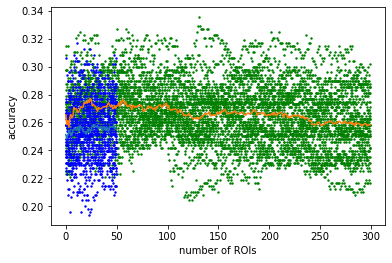

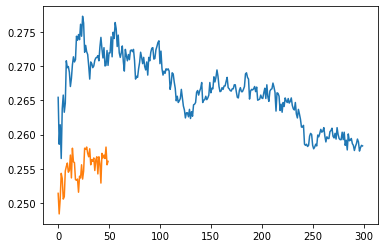

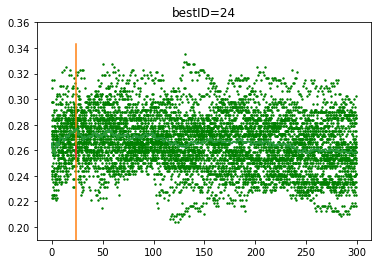

In [1]:
# code to load and compare the result of above:
from glob import glob
import numpy as np
# di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"
# subs=glob(f"{di}[0,1]*_neurosketch")
# subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
# subjects=""
# for sub in subs:
#     subjects=subjects+sub+" "


testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subs=subjects_correctly_aligned
subjects=subs #["0110171", "0110172", "0111171"]
hemis=["lh", "rh"]

wangAcc=np.zeros((50,len(subs)))
roiloc="wang2014"
for sub_i,sub in enumerate(subjects):
    for num in range(1,51):
        try:
            wangAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/uniMaskRank2_top{num}.npy")
        # print(f"{roiloc} {sub} {num} ROIs acc={wangAcc[num-1,sub_i]}")
        except:
            pass

schaeferAcc=np.zeros((300,len(subs)))
roiloc="schaefer2018"
for sub_i,sub in enumerate(subjects):
    for num in range(1,301):
        try:
            schaeferAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/uniMaskRank2_top{num}.npy")
        # print(f"{roiloc} {sub} {num} ROIs acc={schaeferAcc[num-1,sub_i]}")
        except:
            pass


wangAcc=wangAcc[:,wangAcc[0]!=0]
schaeferAcc=schaeferAcc[:,schaeferAcc[0]!=0]
schaeferAcc[schaeferAcc==0]=None

import matplotlib.pyplot as plt
plt.plot(np.nanmean(wangAcc,axis=1))
plt.plot(np.nanmean(schaeferAcc,axis=1))


for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i],c='b',s=2)

plt.xlabel("number of ROIs")
plt.ylabel("accuracy")
# plt.savefig('SummaryAccuracy.png')


plt.figure()
plt.plot(np.mean(schaeferAcc,axis=1))
plt.plot(np.mean(wangAcc,axis=1))


schaeferAcc_mean=np.mean(schaeferAcc,axis=1)
bestID=np.where(schaeferAcc_mean==np.nanmax(schaeferAcc_mean))[0][0]
_=plt.figure()
for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
plt.plot(np.arange(schaeferAcc.shape[0]),np.nanmean(schaeferAcc,axis=1))
plt.ylim([0.19,0.36])
plt.plot([bestID]*10,np.arange(0.19,0.36,(0.36-0.19)/10))


plt.plot(np.arange(schaeferAcc.shape[0]),np.nanmean(schaeferAcc,axis=1))
plt.plot([bestID]*10,np.arange(0.255,0.264,(0.264-0.255)/10))
plt.title(f"bestID={bestID}")


Text(0.5, 1.0, 'bestID=24')

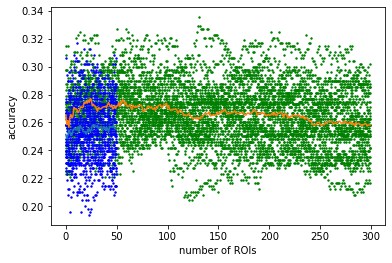

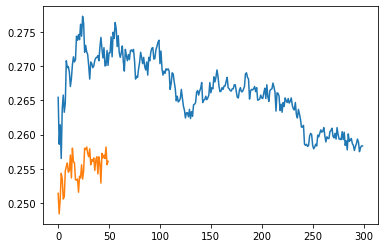

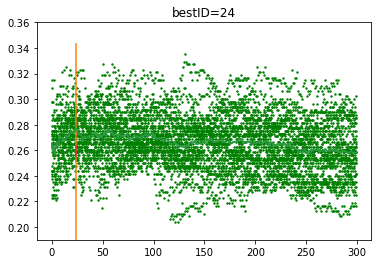

In [21]:
# code to load and compare the result of above:
from glob import glob
import numpy as np
# di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"
# subs=glob(f"{di}[0,1]*_neurosketch")
# subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
# subjects=""
# for sub in subs:
#     subjects=subjects+sub+" "

tag="tag2"
testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subs=subjects_correctly_aligned
subjects=subs #["0110171", "0110172", "0111171"]
hemis=["lh", "rh"]

wangAcc=np.zeros((50,len(subs)))
roiloc="wang2014"
for sub_i,sub in enumerate(subjects):
    for num in range(1,51):
        try:
            wangAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/uniMaskRank{tag}_top{num}.npy")
        # print(f"{roiloc} {sub} {num} ROIs acc={wangAcc[num-1,sub_i]}")
        except:
            pass

schaeferAcc=np.zeros((300,len(subs)))
roiloc="schaefer2018"
for sub_i,sub in enumerate(subjects):
    for num in range(1,301):
        try:
            schaeferAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/uniMaskRank{tag}_top{num}.npy")
        # print(f"{roiloc} {sub} {num} ROIs acc={schaeferAcc[num-1,sub_i]}")
        except:
            pass


wangAcc=wangAcc[:,wangAcc[0]!=0]
schaeferAcc=schaeferAcc[:,schaeferAcc[0]!=0]
schaeferAcc[schaeferAcc==0]=None

import matplotlib.pyplot as plt
plt.plot(np.nanmean(wangAcc,axis=1))
plt.plot(np.nanmean(schaeferAcc,axis=1))


for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i],c='b',s=2)

plt.xlabel("number of ROIs")
plt.ylabel("accuracy")
# plt.savefig('SummaryAccuracy.png')


plt.figure()
plt.plot(np.mean(schaeferAcc,axis=1))
plt.plot(np.mean(wangAcc,axis=1))


schaeferAcc_mean=np.mean(schaeferAcc,axis=1)
bestID=np.where(schaeferAcc_mean==np.nanmax(schaeferAcc_mean))[0][0]
_=plt.figure()
for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
plt.plot(np.arange(schaeferAcc.shape[0]),np.nanmean(schaeferAcc,axis=1))
plt.ylim([0.19,0.36])
plt.plot([bestID]*10,np.arange(0.19,0.36,(0.36-0.19)/10))


plt.plot(np.arange(schaeferAcc.shape[0]),np.nanmean(schaeferAcc,axis=1))
plt.plot([bestID]*10,np.arange(0.255,0.264,(0.264-0.255)/10))
plt.title(f"bestID={bestID}")


Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=1
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #1 
mask dimensions: (94, 94, 72)
number of voxels in mask: 277
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 277) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 277) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 277) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 277) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 277) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 277) shape of mask (94, 94, 72)
Runs shape (6, 80, 277)
(6, 80, 277)
shape of data: (6, 80, 277)
(6, 80, 277)
results of classifier: 0.25833333333333336, type: <class 'numpy.float64'>
total time: 15.743434190750122, searchlight time: 0.2178339958190918


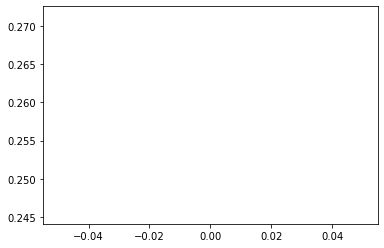

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=2
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #2 
mask dimensions: (94, 94, 72)
number of voxels in mask: 341
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 341) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 341) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 341) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 341) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 341) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 341) shape of mask (94, 94, 72)
Runs shape (6, 80, 341)
(6, 80, 341)
shape of data: (6, 80, 341)
(6, 80, 341)
results of classifier: 0.22708333333333333, type: <class 'numpy.float64'>
total time: 15.639624834060669, searchlight time: 0.20192766189575195


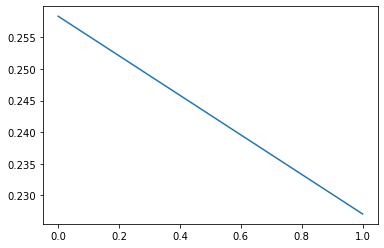

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=3
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #3 
mask dimensions: (94, 94, 72)
number of voxels in mask: 297
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 297) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 297) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 297) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 297) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 297) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 297) shape of mask (94, 94, 72)
Runs shape (6, 80, 297)
(6, 80, 297)
shape of data: (6, 80, 297)
(6, 80, 297)
results of classifier: 0.27708333333333335, type: <class 'numpy.float64'>
total time: 15.745697021484375, searchlight time: 0.3844175338745117


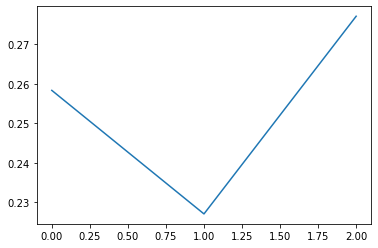

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=4
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #4 
mask dimensions: (94, 94, 72)
number of voxels in mask: 272
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
Runs shape (6, 80, 272)
(6, 80, 272)
shape of data: (6, 80, 272)
(6, 80, 272)
results of classifier: 0.24166666666666667, type: <class 'numpy.float64'>
total time: 15.64609432220459, searchlight time: 0.2163381576538086


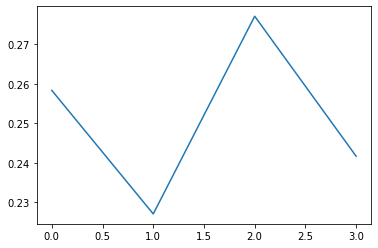

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=5
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #5 
mask dimensions: (94, 94, 72)
number of voxels in mask: 226
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 226) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 226) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 226) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 226) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 226) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 226) shape of mask (94, 94, 72)
Runs shape (6, 80, 226)
(6, 80, 226)
shape of data: (6, 80, 226)
(6, 80, 226)
results of classifier: 0.25833333333333336, type: <class 'numpy.float64'>
total time: 15.923737525939941, searchlight time: 0.29337000846862793


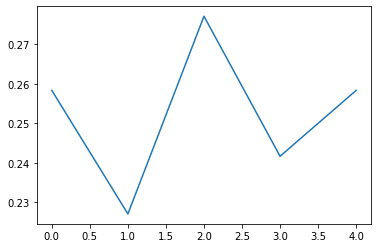

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=6
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #6 
mask dimensions: (94, 94, 72)
number of voxels in mask: 336
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
Runs shape (6, 80, 336)
(6, 80, 336)
shape of data: (6, 80, 336)
(6, 80, 336)
results of classifier: 0.29375, type: <class 'numpy.float64'>
total time: 15.776184797286987, searchlight time: 0.4032711982727051


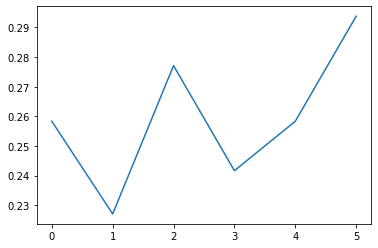

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=7
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #7 
mask dimensions: (94, 94, 72)
number of voxels in mask: 75
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 75) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 75) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 75) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 75) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 75) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 75) shape of mask (94, 94, 72)
Runs shape (6, 80, 75)
(6, 80, 75)
shape of data: (6, 80, 75)
(6, 80, 75)
results of classifier: 0.19999999999999998, type: <class 'numpy.float64'>
total time: 15.517390012741089, searchlight time: 0.06773805618286133


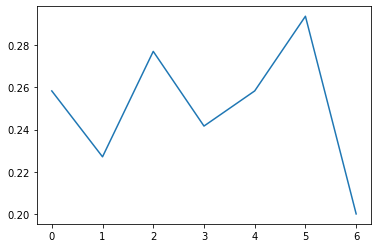

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=8
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #8 
mask dimensions: (94, 94, 72)
number of voxels in mask: 313
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 313) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 313) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 313) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 313) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 313) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 313) shape of mask (94, 94, 72)
Runs shape (6, 80, 313)
(6, 80, 313)
shape of data: (6, 80, 313)
(6, 80, 313)
results of classifier: 0.225, type: <class 'numpy.float64'>
total time: 15.825702667236328, searchlight time: 0.37522363662719727


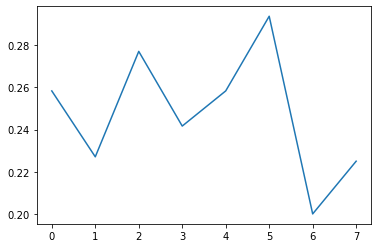

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=9
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #9 
mask dimensions: (94, 94, 72)
number of voxels in mask: 195
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 195) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 195) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 195) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 195) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 195) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 195) shape of mask (94, 94, 72)
Runs shape (6, 80, 195)
(6, 80, 195)
shape of data: (6, 80, 195)
(6, 80, 195)
results of classifier: 0.2416666666666667, type: <class 'numpy.float64'>
total time: 15.808477878570557, searchlight time: 0.24699759483337402


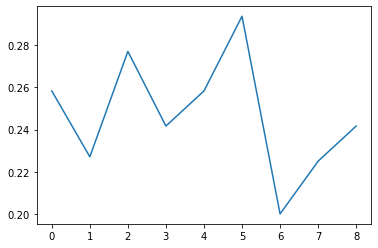

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=10
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #10 
mask dimensions: (94, 94, 72)
number of voxels in mask: 196
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 196) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 196) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 196) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 196) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 196) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 196) shape of mask (94, 94, 72)
Runs shape (6, 80, 196)
(6, 80, 196)
shape of data: (6, 80, 196)
(6, 80, 196)
results of classifier: 0.23541666666666664, type: <class 'numpy.float64'>
total time: 15.76025652885437, searchlight time: 0.3289639949798584


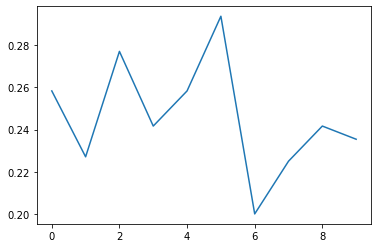

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=11
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #11 
mask dimensions: (94, 94, 72)
number of voxels in mask: 397
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 397) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 397) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 397) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 397) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 397) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 397) shape of mask (94, 94, 72)
Runs shape (6, 80, 397)
(6, 80, 397)
shape of data: (6, 80, 397)
(6, 80, 397)
results of classifier: 0.2541666666666667, type: <class 'numpy.float64'>
total time: 15.823099851608276, searchlight time: 0.3249063491821289


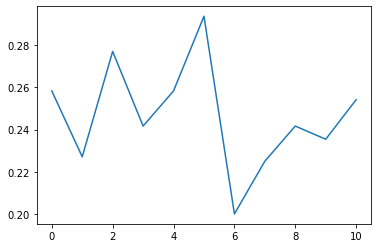

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=12
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #12 
mask dimensions: (94, 94, 72)
number of voxels in mask: 183
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 183) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 183) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 183) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 183) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 183) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 183) shape of mask (94, 94, 72)
Runs shape (6, 80, 183)
(6, 80, 183)
shape of data: (6, 80, 183)
(6, 80, 183)
results of classifier: 0.2562499999999999, type: <class 'numpy.float64'>
total time: 15.592772483825684, searchlight time: 0.24386358261108398


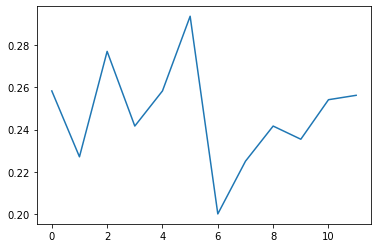

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=13
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #13 
mask dimensions: (94, 94, 72)
number of voxels in mask: 293
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 293) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 293) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 293) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 293) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 293) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 293) shape of mask (94, 94, 72)
Runs shape (6, 80, 293)
(6, 80, 293)
shape of data: (6, 80, 293)
(6, 80, 293)
results of classifier: 0.20625000000000002, type: <class 'numpy.float64'>
total time: 15.899316310882568, searchlight time: 0.25008177757263184


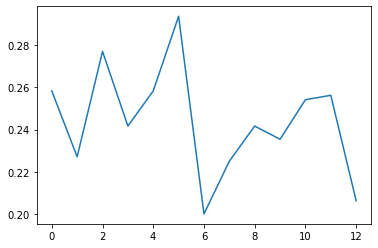

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=14
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #14 
mask dimensions: (94, 94, 72)
number of voxels in mask: 506
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 506) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 506) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 506) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 506) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 506) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 506) shape of mask (94, 94, 72)
Runs shape (6, 80, 506)
(6, 80, 506)
shape of data: (6, 80, 506)
(6, 80, 506)
results of classifier: 0.2520833333333333, type: <class 'numpy.float64'>
total time: 15.804210901260376, searchlight time: 0.43587565422058105


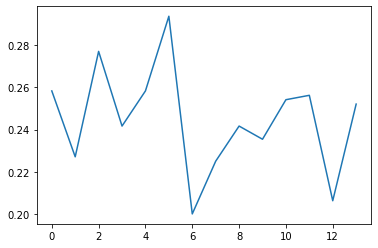

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=15
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #15 
mask dimensions: (94, 94, 72)
number of voxels in mask: 518
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 518) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 518) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 518) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 518) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 518) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 518) shape of mask (94, 94, 72)
Runs shape (6, 80, 518)
(6, 80, 518)
shape of data: (6, 80, 518)
(6, 80, 518)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


results of classifier: 0.22708333333333333, type: <class 'numpy.float64'>
total time: 15.660471677780151, searchlight time: 0.36815857887268066


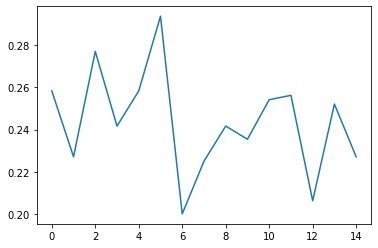

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=16
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #16 
mask dimensions: (94, 94, 72)
number of voxels in mask: 409
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 409) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 409) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 409) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 409) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 409) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 409) shape of mask (94, 94, 72)
Runs shape (6, 80, 409)
(6, 80, 409)
shape of data: (6, 80, 409)
(6, 80, 409)
results of classifier: 0.22083333333333333, type: <class 'numpy.float64'>
total time: 15.94497561454773, searchlight time: 0.26337432861328125


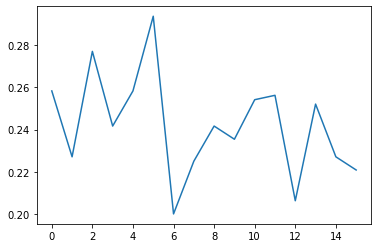

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=17
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #17 
mask dimensions: (94, 94, 72)
number of voxels in mask: 204
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
Runs shape (6, 80, 204)
(6, 80, 204)
shape of data: (6, 80, 204)
(6, 80, 204)
results of classifier: 0.23749999999999996, type: <class 'numpy.float64'>
total time: 15.77651596069336, searchlight time: 0.25238752365112305


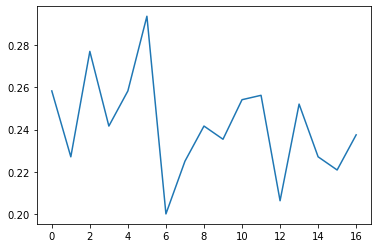

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=18
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #18 
mask dimensions: (94, 94, 72)
number of voxels in mask: 388
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
Runs shape (6, 80, 388)
(6, 80, 388)
shape of data: (6, 80, 388)
(6, 80, 388)
results of classifier: 0.22291666666666665, type: <class 'numpy.float64'>
total time: 15.694855451583862, searchlight time: 0.28705930709838867


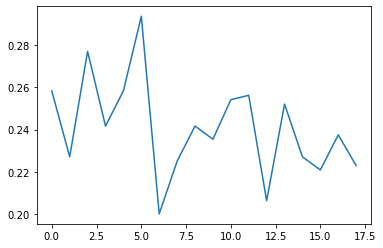

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=19
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #19 
mask dimensions: (94, 94, 72)
number of voxels in mask: 496
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 496) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 496) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 496) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 496) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 496) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 496) shape of mask (94, 94, 72)
Runs shape (6, 80, 496)
(6, 80, 496)
shape of data: (6, 80, 496)
(6, 80, 496)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


results of classifier: 0.25416666666666665, type: <class 'numpy.float64'>
total time: 16.13727068901062, searchlight time: 0.3290116786956787


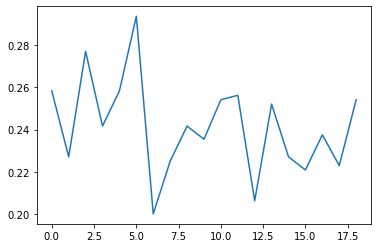

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=20
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #20 
mask dimensions: (94, 94, 72)
number of voxels in mask: 295
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 295) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 295) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 295) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 295) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 295) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 295) shape of mask (94, 94, 72)
Runs shape (6, 80, 295)
(6, 80, 295)
shape of data: (6, 80, 295)
(6, 80, 295)
results of classifier: 0.25625, type: <class 'numpy.float64'>
total time: 16.019500970840454, searchlight time: 0.2717769145965576


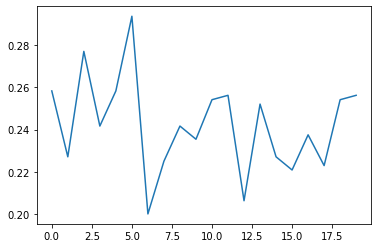

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=21
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #21 
mask dimensions: (94, 94, 72)
number of voxels in mask: 280
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 280) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 280) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 280) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 280) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 280) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 280) shape of mask (94, 94, 72)
Runs shape (6, 80, 280)
(6, 80, 280)
shape of data: (6, 80, 280)
(6, 80, 280)
results of classifier: 0.22083333333333333, type: <class 'numpy.float64'>
total time: 15.766023635864258, searchlight time: 0.2056889533996582


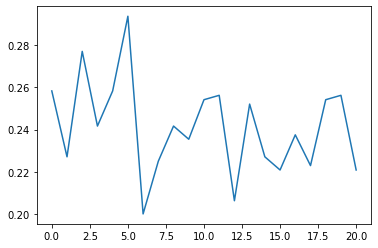

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=22
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #22 
mask dimensions: (94, 94, 72)
number of voxels in mask: 304
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 304) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 304) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 304) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 304) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 304) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 304) shape of mask (94, 94, 72)
Runs shape (6, 80, 304)
(6, 80, 304)
shape of data: (6, 80, 304)
(6, 80, 304)
results of classifier: 0.25, type: <class 'numpy.float64'>
total time: 15.769304752349854, searchlight time: 0.26398730278015137


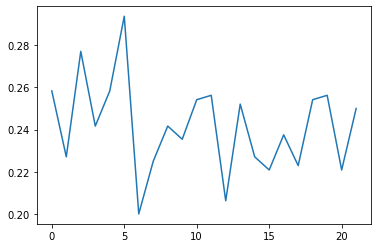

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=23
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #23 
mask dimensions: (94, 94, 72)
number of voxels in mask: 302
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 302) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 302) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 302) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 302) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 302) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 302) shape of mask (94, 94, 72)
Runs shape (6, 80, 302)
(6, 80, 302)
shape of data: (6, 80, 302)
(6, 80, 302)
results of classifier: 0.2354166666666667, type: <class 'numpy.float64'>
total time: 16.000311374664307, searchlight time: 0.3286552429199219


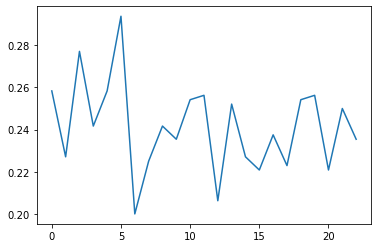

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=24
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #24 
mask dimensions: (94, 94, 72)
number of voxels in mask: 108
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 108) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 108) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 108) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 108) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 108) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 108) shape of mask (94, 94, 72)
Runs shape (6, 80, 108)
(6, 80, 108)
shape of data: (6, 80, 108)
(6, 80, 108)
results of classifier: 0.26458333333333334, type: <class 'numpy.float64'>
total time: 15.79197883605957, searchlight time: 0.1767890453338623


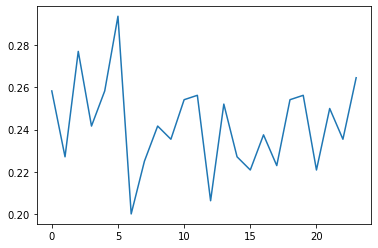

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=25
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #25 
mask dimensions: (94, 94, 72)
number of voxels in mask: 288
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
Runs shape (6, 80, 288)
(6, 80, 288)
shape of data: (6, 80, 288)
(6, 80, 288)
results of classifier: 0.2041666666666667, type: <class 'numpy.float64'>
total time: 15.695213794708252, searchlight time: 0.23911190032958984


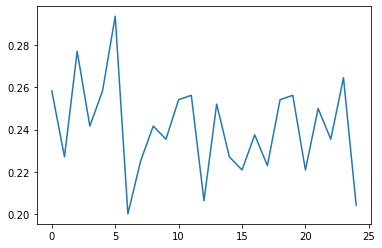

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=26
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #26 
mask dimensions: (94, 94, 72)
number of voxels in mask: 431
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 431) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 431) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 431) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 431) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 431) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 431) shape of mask (94, 94, 72)
Runs shape (6, 80, 431)
(6, 80, 431)
shape of data: (6, 80, 431)
(6, 80, 431)
results of classifier: 0.28541666666666665, type: <class 'numpy.float64'>
total time: 15.69013261795044, searchlight time: 0.24117112159729004


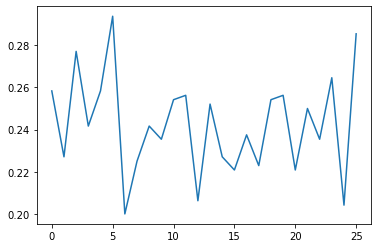

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=27
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #27 
mask dimensions: (94, 94, 72)
number of voxels in mask: 119
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 119) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 119) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 119) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 119) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 119) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 119) shape of mask (94, 94, 72)
Runs shape (6, 80, 119)
(6, 80, 119)
shape of data: (6, 80, 119)
(6, 80, 119)
results of classifier: 0.27499999999999997, type: <class 'numpy.float64'>
total time: 15.901947736740112, searchlight time: 0.1403186321258545


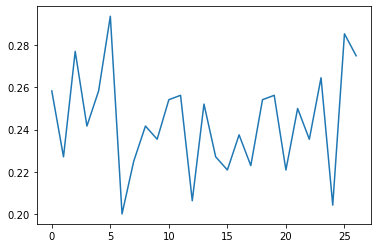

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=28
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #28 
mask dimensions: (94, 94, 72)
number of voxels in mask: 180
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
Runs shape (6, 80, 180)
(6, 80, 180)
shape of data: (6, 80, 180)
(6, 80, 180)
results of classifier: 0.23750000000000002, type: <class 'numpy.float64'>
total time: 16.296374082565308, searchlight time: 0.2472391128540039


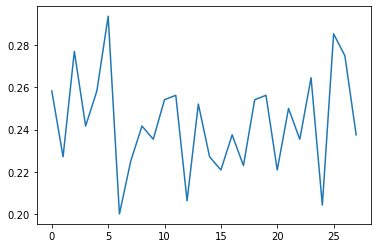

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=29
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #29 
mask dimensions: (94, 94, 72)
number of voxels in mask: 156
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
Runs shape (6, 80, 156)
(6, 80, 156)
shape of data: (6, 80, 156)
(6, 80, 156)
results of classifier: 0.27291666666666664, type: <class 'numpy.float64'>
total time: 15.983504056930542, searchlight time: 0.22528624534606934


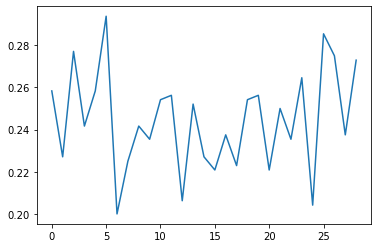

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=30
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #30 
mask dimensions: (94, 94, 72)
number of voxels in mask: 284
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 284) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 284) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 284) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 284) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 284) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 284) shape of mask (94, 94, 72)
Runs shape (6, 80, 284)
(6, 80, 284)
shape of data: (6, 80, 284)
(6, 80, 284)
results of classifier: 0.26666666666666666, type: <class 'numpy.float64'>
total time: 15.897198677062988, searchlight time: 0.2209000587463379


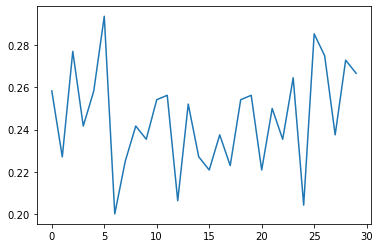

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=31
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #31 
mask dimensions: (94, 94, 72)
number of voxels in mask: 208
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
Runs shape (6, 80, 208)
(6, 80, 208)
shape of data: (6, 80, 208)
(6, 80, 208)
results of classifier: 0.28125, type: <class 'numpy.float64'>
total time: 15.973490715026855, searchlight time: 0.25450921058654785


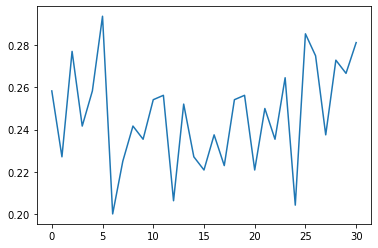

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=32
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #32 
mask dimensions: (94, 94, 72)
number of voxels in mask: 163
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 163) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 163) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 163) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 163) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 163) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 163) shape of mask (94, 94, 72)
Runs shape (6, 80, 163)
(6, 80, 163)
shape of data: (6, 80, 163)
(6, 80, 163)
results of classifier: 0.24583333333333335, type: <class 'numpy.float64'>
total time: 15.769263505935669, searchlight time: 0.23775196075439453


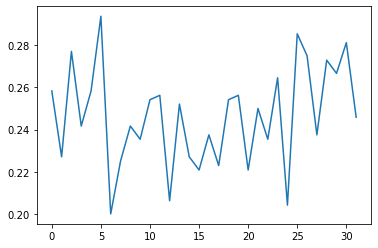

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=33
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #33 
mask dimensions: (94, 94, 72)
number of voxels in mask: 156
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 156) shape of mask (94, 94, 72)
Runs shape (6, 80, 156)
(6, 80, 156)
shape of data: (6, 80, 156)
(6, 80, 156)
results of classifier: 0.25, type: <class 'numpy.float64'>
total time: 15.75505256652832, searchlight time: 0.211181640625


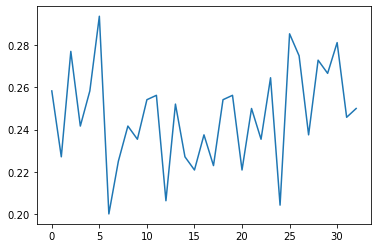

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=34
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #34 
mask dimensions: (94, 94, 72)
number of voxels in mask: 423
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 423) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 423) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 423) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 423) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 423) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 423) shape of mask (94, 94, 72)
Runs shape (6, 80, 423)
(6, 80, 423)
shape of data: (6, 80, 423)
(6, 80, 423)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


results of classifier: 0.27708333333333335, type: <class 'numpy.float64'>
total time: 15.899940490722656, searchlight time: 0.22590255737304688


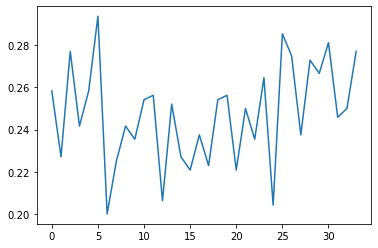

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=35
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #35 
mask dimensions: (94, 94, 72)
number of voxels in mask: 352
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 352) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 352) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 352) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 352) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 352) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 352) shape of mask (94, 94, 72)
Runs shape (6, 80, 352)
(6, 80, 352)
shape of data: (6, 80, 352)
(6, 80, 352)
results of classifier: 0.2645833333333333, type: <class 'numpy.float64'>
total time: 16.141558408737183, searchlight time: 0.354931116104126


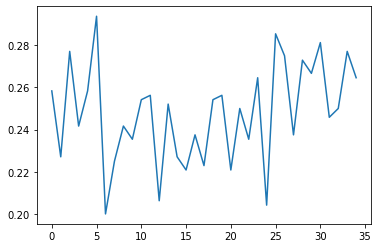

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=36
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #36 
mask dimensions: (94, 94, 72)
number of voxels in mask: 207
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 207) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 207) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 207) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 207) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 207) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 207) shape of mask (94, 94, 72)
Runs shape (6, 80, 207)
(6, 80, 207)
shape of data: (6, 80, 207)
(6, 80, 207)
results of classifier: 0.29583333333333334, type: <class 'numpy.float64'>
total time: 16.003891468048096, searchlight time: 0.25310277938842773


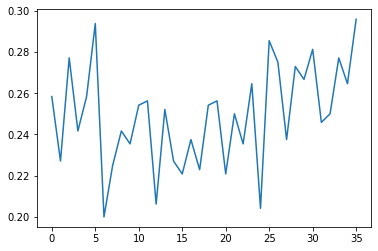

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=37
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #37 
mask dimensions: (94, 94, 72)
number of voxels in mask: 96
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 96) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 96) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 96) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 96) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 96) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 96) shape of mask (94, 94, 72)
Runs shape (6, 80, 96)
(6, 80, 96)
shape of data: (6, 80, 96)
(6, 80, 96)
results of classifier: 0.30625, type: <class 'numpy.float64'>
total time: 15.718382596969604, searchlight time: 0.09389805793762207


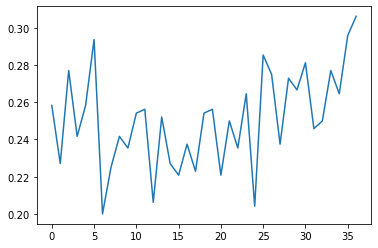

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=38
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #38 
mask dimensions: (94, 94, 72)
number of voxels in mask: 272
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 272) shape of mask (94, 94, 72)
Runs shape (6, 80, 272)
(6, 80, 272)
shape of data: (6, 80, 272)
(6, 80, 272)
results of classifier: 0.26875000000000004, type: <class 'numpy.float64'>
total time: 15.991622686386108, searchlight time: 0.35059356689453125


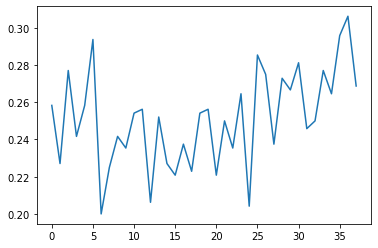

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=39
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #39 
mask dimensions: (94, 94, 72)
number of voxels in mask: 154
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 154) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 154) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 154) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 154) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 154) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 154) shape of mask (94, 94, 72)
Runs shape (6, 80, 154)
(6, 80, 154)
shape of data: (6, 80, 154)
(6, 80, 154)
results of classifier: 0.2520833333333333, type: <class 'numpy.float64'>
total time: 15.810001850128174, searchlight time: 0.2525899410247803


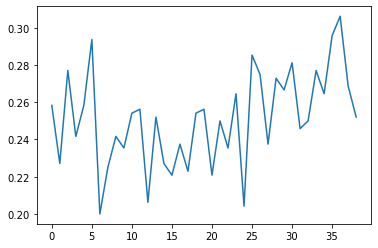

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=40
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #40 
mask dimensions: (94, 94, 72)
number of voxels in mask: 288
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 288) shape of mask (94, 94, 72)
Runs shape (6, 80, 288)
(6, 80, 288)
shape of data: (6, 80, 288)
(6, 80, 288)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


results of classifier: 0.22083333333333333, type: <class 'numpy.float64'>
total time: 15.932613849639893, searchlight time: 0.3782205581665039


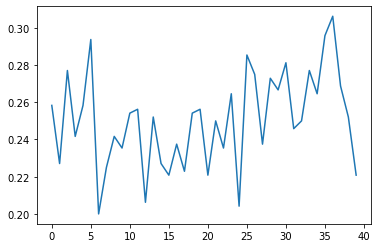

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=41
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #41 
mask dimensions: (94, 94, 72)
number of voxels in mask: 191
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
Runs shape (6, 80, 191)
(6, 80, 191)
shape of data: (6, 80, 191)
(6, 80, 191)
results of classifier: 0.25416666666666665, type: <class 'numpy.float64'>
total time: 15.963801622390747, searchlight time: 0.2536814212799072


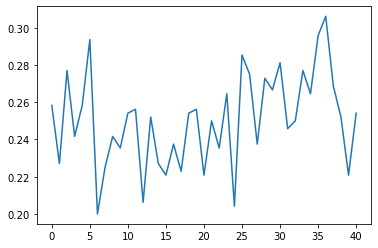

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=42
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #42 
mask dimensions: (94, 94, 72)
number of voxels in mask: 140
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 140) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 140) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 140) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 140) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 140) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 140) shape of mask (94, 94, 72)
Runs shape (6, 80, 140)
(6, 80, 140)
shape of data: (6, 80, 140)
(6, 80, 140)
results of classifier: 0.23333333333333336, type: <class 'numpy.float64'>
total time: 15.787139654159546, searchlight time: 0.2099473476409912


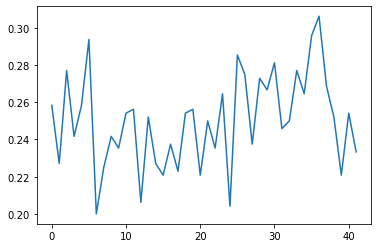

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=43
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #43 
mask dimensions: (94, 94, 72)
number of voxels in mask: 319
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 319) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 319) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 319) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 319) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 319) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 319) shape of mask (94, 94, 72)
Runs shape (6, 80, 319)
(6, 80, 319)
shape of data: (6, 80, 319)
(6, 80, 319)
results of classifier: 0.20625000000000002, type: <class 'numpy.float64'>
total time: 16.567959308624268, searchlight time: 0.331575870513916


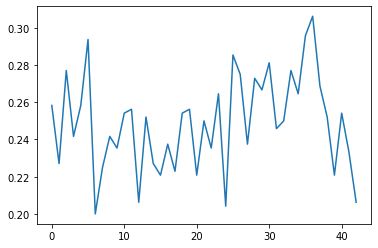

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=44
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #44 
mask dimensions: (94, 94, 72)
number of voxels in mask: 191
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 191) shape of mask (94, 94, 72)
Runs shape (6, 80, 191)
(6, 80, 191)
shape of data: (6, 80, 191)
(6, 80, 191)
results of classifier: 0.2520833333333333, type: <class 'numpy.float64'>
total time: 16.234477281570435, searchlight time: 0.555469274520874


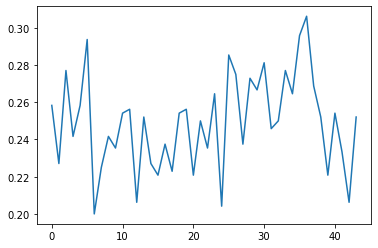

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=45
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #45 
mask dimensions: (94, 94, 72)
number of voxels in mask: 265
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
Runs shape (6, 80, 265)
(6, 80, 265)
shape of data: (6, 80, 265)
(6, 80, 265)
results of classifier: 0.28958333333333336, type: <class 'numpy.float64'>
total time: 15.982072591781616, searchlight time: 0.27880430221557617


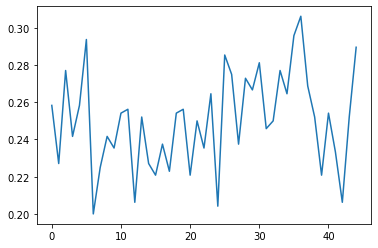

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=46
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #46 
mask dimensions: (94, 94, 72)
number of voxels in mask: 182
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 182) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 182) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 182) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 182) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 182) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 182) shape of mask (94, 94, 72)
Runs shape (6, 80, 182)
(6, 80, 182)
shape of data: (6, 80, 182)
(6, 80, 182)
results of classifier: 0.2625, type: <class 'numpy.float64'>
total time: 16.461349725723267, searchlight time: 0.2632594108581543


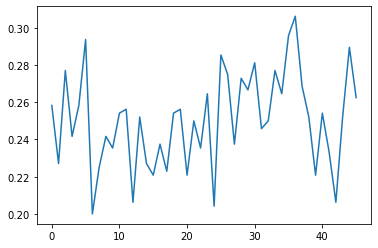

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=47
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #47 
mask dimensions: (94, 94, 72)
number of voxels in mask: 238
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 238) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 238) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 238) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 238) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 238) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 238) shape of mask (94, 94, 72)
Runs shape (6, 80, 238)
(6, 80, 238)
shape of data: (6, 80, 238)
(6, 80, 238)
results of classifier: 0.22916666666666666, type: <class 'numpy.float64'>
total time: 16.409043073654175, searchlight time: 0.3425471782684326


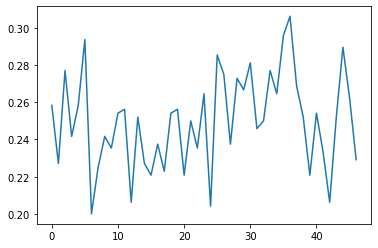

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=48
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #48 
mask dimensions: (94, 94, 72)
number of voxels in mask: 309
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 309) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 309) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 309) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 309) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 309) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 309) shape of mask (94, 94, 72)
Runs shape (6, 80, 309)
(6, 80, 309)
shape of data: (6, 80, 309)
(6, 80, 309)
results of classifier: 0.2416666666666667, type: <class 'numpy.float64'>
total time: 16.23912525177002, searchlight time: 0.28650355339050293


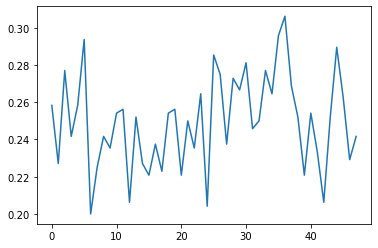

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=49
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #49 
mask dimensions: (94, 94, 72)
number of voxels in mask: 240
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 240) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 240) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 240) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 240) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 240) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 240) shape of mask (94, 94, 72)
Runs shape (6, 80, 240)
(6, 80, 240)
shape of data: (6, 80, 240)
(6, 80, 240)
results of classifier: 0.24999999999999997, type: <class 'numpy.float64'>
total time: 16.086573123931885, searchlight time: 0.29340052604675293


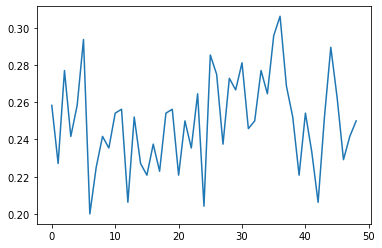

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=50
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #50 
mask dimensions: (94, 94, 72)
number of voxels in mask: 333
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 333) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 333) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 333) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 333) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 333) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 333) shape of mask (94, 94, 72)
Runs shape (6, 80, 333)
(6, 80, 333)
shape of data: (6, 80, 333)
(6, 80, 333)
results of classifier: 0.2041666666666667, type: <class 'numpy.float64'>
total time: 16.993818998336792, searchlight time: 0.3666093349456787


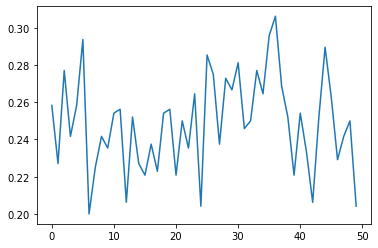

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=51
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #51 
mask dimensions: (94, 94, 72)
number of voxels in mask: 242
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 242) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 242) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 242) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 242) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 242) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 242) shape of mask (94, 94, 72)
Runs shape (6, 80, 242)
(6, 80, 242)
shape of data: (6, 80, 242)
(6, 80, 242)
results of classifier: 0.2479166666666667, type: <class 'numpy.float64'>
total time: 15.80282735824585, searchlight time: 0.33994626998901367


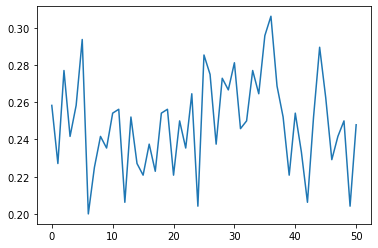

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=52
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #52 
mask dimensions: (94, 94, 72)
number of voxels in mask: 185
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 185) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 185) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 185) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 185) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 185) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 185) shape of mask (94, 94, 72)
Runs shape (6, 80, 185)
(6, 80, 185)
shape of data: (6, 80, 185)
(6, 80, 185)
results of classifier: 0.21875, type: <class 'numpy.float64'>
total time: 15.92947769165039, searchlight time: 0.327833890914917


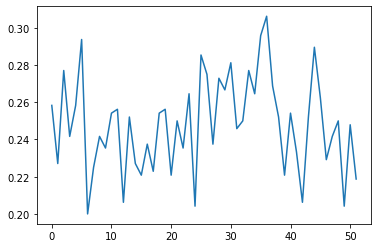

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=53
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #53 
mask dimensions: (94, 94, 72)
number of voxels in mask: 146
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 146) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 146) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 146) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 146) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 146) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 146) shape of mask (94, 94, 72)
Runs shape (6, 80, 146)
(6, 80, 146)
shape of data: (6, 80, 146)
(6, 80, 146)
results of classifier: 0.26875, type: <class 'numpy.float64'>
total time: 15.882665872573853, searchlight time: 0.24085712432861328


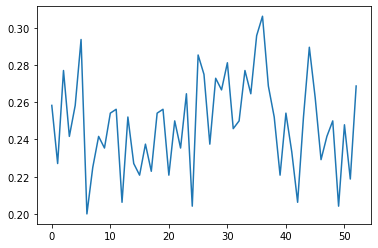

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=54
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #54 
mask dimensions: (94, 94, 72)
number of voxels in mask: 528
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 528) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 528) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 528) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 528) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 528) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 528) shape of mask (94, 94, 72)
Runs shape (6, 80, 528)
(6, 80, 528)
shape of data: (6, 80, 528)
(6, 80, 528)
results of classifier: 0.3104166666666666, type: <class 'numpy.float64'>
total time: 16.078478813171387, searchlight time: 0.28043031692504883


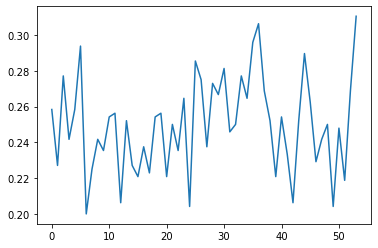

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=55
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #55 
mask dimensions: (94, 94, 72)
number of voxels in mask: 445
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 445) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 445) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 445) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 445) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 445) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 445) shape of mask (94, 94, 72)
Runs shape (6, 80, 445)
(6, 80, 445)
shape of data: (6, 80, 445)
(6, 80, 445)
results of classifier: 0.2541666666666667, type: <class 'numpy.float64'>
total time: 15.947954177856445, searchlight time: 0.27640652656555176


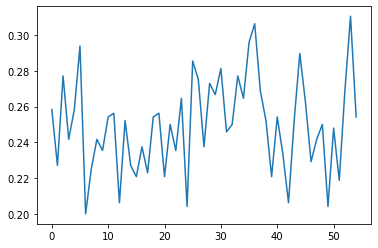

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=56
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #56 
mask dimensions: (94, 94, 72)
number of voxels in mask: 307
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 307) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 307) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 307) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 307) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 307) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 307) shape of mask (94, 94, 72)
Runs shape (6, 80, 307)
(6, 80, 307)
shape of data: (6, 80, 307)
(6, 80, 307)
results of classifier: 0.29791666666666666, type: <class 'numpy.float64'>
total time: 15.933650970458984, searchlight time: 0.2540924549102783


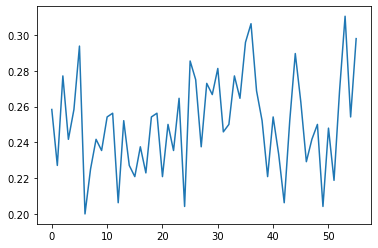

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=57
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #57 
mask dimensions: (94, 94, 72)
number of voxels in mask: 265
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 265) shape of mask (94, 94, 72)
Runs shape (6, 80, 265)
(6, 80, 265)
shape of data: (6, 80, 265)
(6, 80, 265)
results of classifier: 0.23750000000000002, type: <class 'numpy.float64'>
total time: 16.060718297958374, searchlight time: 0.25409793853759766


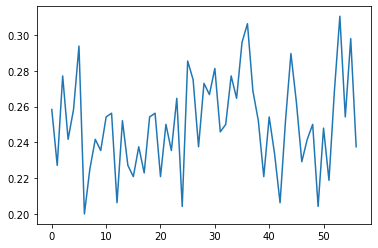

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=58
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #58 
mask dimensions: (94, 94, 72)
number of voxels in mask: 311
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 311) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 311) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 311) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 311) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 311) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 311) shape of mask (94, 94, 72)
Runs shape (6, 80, 311)
(6, 80, 311)
shape of data: (6, 80, 311)
(6, 80, 311)
results of classifier: 0.24375000000000002, type: <class 'numpy.float64'>
total time: 16.455437183380127, searchlight time: 0.26021456718444824


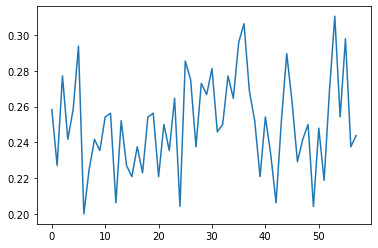

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=59
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #59 
mask dimensions: (94, 94, 72)
number of voxels in mask: 219
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 219) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 219) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 219) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 219) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 219) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 219) shape of mask (94, 94, 72)
Runs shape (6, 80, 219)
(6, 80, 219)
shape of data: (6, 80, 219)
(6, 80, 219)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


results of classifier: 0.22916666666666666, type: <class 'numpy.float64'>
total time: 16.179814338684082, searchlight time: 0.4243941307067871


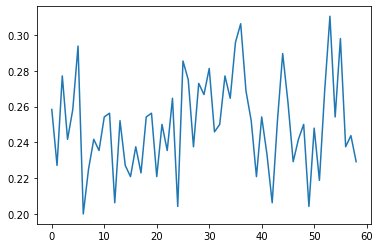

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=60
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #60 
mask dimensions: (94, 94, 72)
number of voxels in mask: 104
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 104) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 104) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 104) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 104) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 104) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 104) shape of mask (94, 94, 72)
Runs shape (6, 80, 104)
(6, 80, 104)
shape of data: (6, 80, 104)
(6, 80, 104)
results of classifier: 0.2354166666666667, type: <class 'numpy.float64'>
total time: 15.961805820465088, searchlight time: 0.09707784652709961


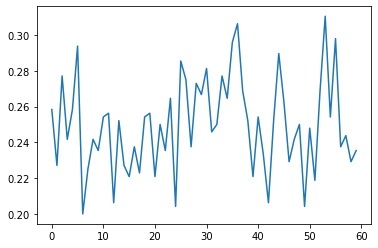

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=61
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #61 
mask dimensions: (94, 94, 72)
number of voxels in mask: 323
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 323) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 323) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 323) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 323) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 323) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 323) shape of mask (94, 94, 72)
Runs shape (6, 80, 323)
(6, 80, 323)
shape of data: (6, 80, 323)
(6, 80, 323)
results of classifier: 0.23333333333333336, type: <class 'numpy.float64'>
total time: 16.08811593055725, searchlight time: 0.2530946731567383


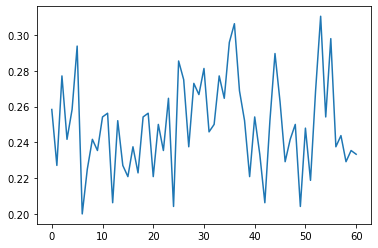

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=62
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #62 
mask dimensions: (94, 94, 72)
number of voxels in mask: 257
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 257) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 257) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 257) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 257) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 257) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 257) shape of mask (94, 94, 72)
Runs shape (6, 80, 257)
(6, 80, 257)
shape of data: (6, 80, 257)
(6, 80, 257)
results of classifier: 0.23958333333333334, type: <class 'numpy.float64'>
total time: 16.204118967056274, searchlight time: 0.2625465393066406


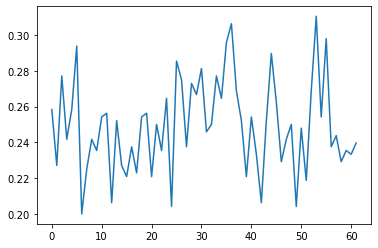

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=63
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #63 
mask dimensions: (94, 94, 72)
number of voxels in mask: 367
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
Runs shape (6, 80, 367)
(6, 80, 367)
shape of data: (6, 80, 367)
(6, 80, 367)
results of classifier: 0.23749999999999996, type: <class 'numpy.float64'>
total time: 16.47515344619751, searchlight time: 0.39803361892700195


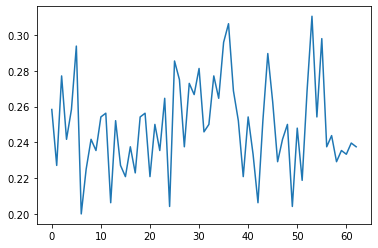

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=64
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #64 
mask dimensions: (94, 94, 72)
number of voxels in mask: 180
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
Runs shape (6, 80, 180)
(6, 80, 180)
shape of data: (6, 80, 180)
(6, 80, 180)
results of classifier: 0.2729166666666667, type: <class 'numpy.float64'>
total time: 16.753047704696655, searchlight time: 0.3318357467651367


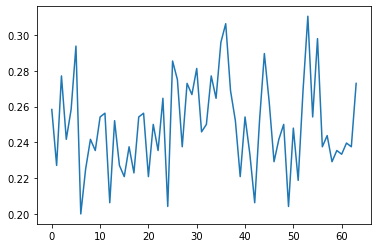

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=65
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #65 
mask dimensions: (94, 94, 72)
number of voxels in mask: 358
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 358) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 358) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 358) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 358) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 358) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 358) shape of mask (94, 94, 72)
Runs shape (6, 80, 358)
(6, 80, 358)
shape of data: (6, 80, 358)
(6, 80, 358)
results of classifier: 0.24791666666666667, type: <class 'numpy.float64'>
total time: 16.582978010177612, searchlight time: 0.3251643180847168


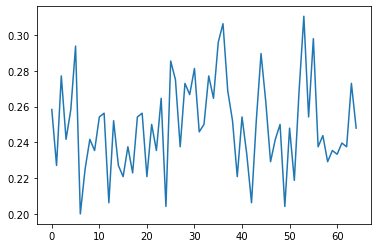

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=66
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #66 
mask dimensions: (94, 94, 72)
number of voxels in mask: 167
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 167) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 167) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 167) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 167) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 167) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 167) shape of mask (94, 94, 72)
Runs shape (6, 80, 167)
(6, 80, 167)
shape of data: (6, 80, 167)
(6, 80, 167)
results of classifier: 0.2583333333333333, type: <class 'numpy.float64'>
total time: 15.98164176940918, searchlight time: 0.38834118843078613


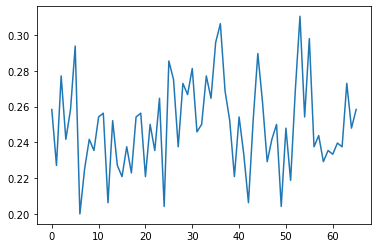

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=67
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #67 
mask dimensions: (94, 94, 72)
number of voxels in mask: 458
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 458) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 458) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 458) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 458) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 458) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 458) shape of mask (94, 94, 72)
Runs shape (6, 80, 458)
(6, 80, 458)
shape of data: (6, 80, 458)
(6, 80, 458)
results of classifier: 0.26666666666666666, type: <class 'numpy.float64'>
total time: 15.982922315597534, searchlight time: 0.2855687141418457


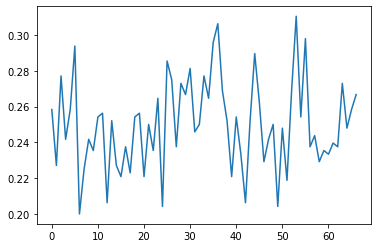

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=68
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #68 
mask dimensions: (94, 94, 72)
number of voxels in mask: 273
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
Runs shape (6, 80, 273)
(6, 80, 273)
shape of data: (6, 80, 273)
(6, 80, 273)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


results of classifier: 0.24375, type: <class 'numpy.float64'>
total time: 16.09732937812805, searchlight time: 0.569263219833374


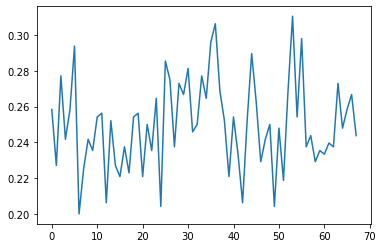

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=69
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #69 
mask dimensions: (94, 94, 72)
number of voxels in mask: 204
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 204) shape of mask (94, 94, 72)
Runs shape (6, 80, 204)
(6, 80, 204)
shape of data: (6, 80, 204)
(6, 80, 204)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


results of classifier: 0.2729166666666667, type: <class 'numpy.float64'>
total time: 15.807637691497803, searchlight time: 0.32773327827453613


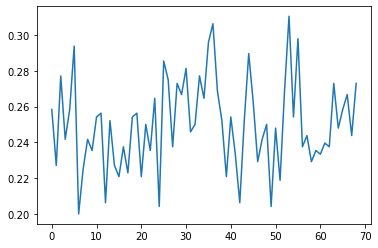

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=70
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #70 
mask dimensions: (94, 94, 72)
number of voxels in mask: 203
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 203) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 203) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 203) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 203) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 203) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 203) shape of mask (94, 94, 72)
Runs shape (6, 80, 203)
(6, 80, 203)
shape of data: (6, 80, 203)
(6, 80, 203)
results of classifier: 0.2604166666666667, type: <class 'numpy.float64'>
total time: 15.682442903518677, searchlight time: 0.28801941871643066


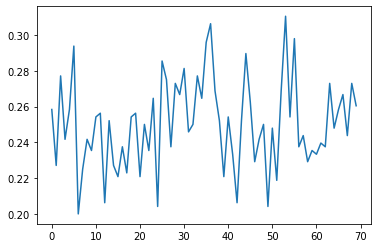

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=71
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #71 
mask dimensions: (94, 94, 72)
number of voxels in mask: 294
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
Runs shape (6, 80, 294)
(6, 80, 294)
shape of data: (6, 80, 294)
(6, 80, 294)
results of classifier: 0.25, type: <class 'numpy.float64'>
total time: 15.771064281463623, searchlight time: 0.26561737060546875


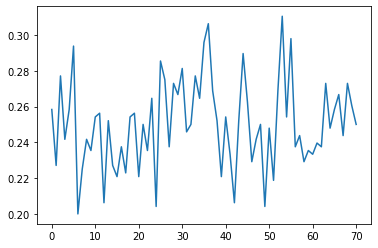

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=72
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #72 
mask dimensions: (94, 94, 72)
number of voxels in mask: 273
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 273) shape of mask (94, 94, 72)
Runs shape (6, 80, 273)
(6, 80, 273)
shape of data: (6, 80, 273)
(6, 80, 273)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


results of classifier: 0.24791666666666667, type: <class 'numpy.float64'>
total time: 16.430803298950195, searchlight time: 0.2864089012145996


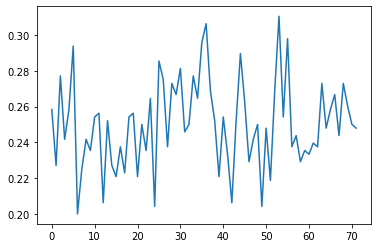

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=73
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #73 
mask dimensions: (94, 94, 72)
number of voxels in mask: 254
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 254) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 254) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 254) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 254) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 254) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 254) shape of mask (94, 94, 72)
Runs shape (6, 80, 254)
(6, 80, 254)
shape of data: (6, 80, 254)
(6, 80, 254)
results of classifier: 0.25, type: <class 'numpy.float64'>
total time: 15.635560989379883, searchlight time: 0.24991464614868164


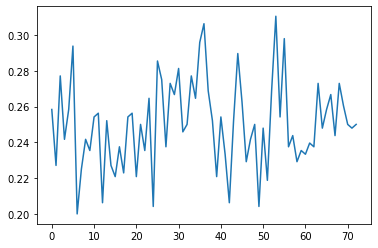

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=74
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #74 
mask dimensions: (94, 94, 72)
number of voxels in mask: 497
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 497) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 497) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 497) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 497) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 497) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 497) shape of mask (94, 94, 72)
Runs shape (6, 80, 497)
(6, 80, 497)
shape of data: (6, 80, 497)
(6, 80, 497)
results of classifier: 0.24375000000000002, type: <class 'numpy.float64'>
total time: 15.618407249450684, searchlight time: 0.251741886138916


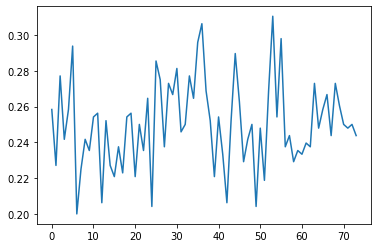

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=75
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #75 
mask dimensions: (94, 94, 72)
number of voxels in mask: 149
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 149) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 149) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 149) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 149) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 149) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 149) shape of mask (94, 94, 72)
Runs shape (6, 80, 149)
(6, 80, 149)
shape of data: (6, 80, 149)
(6, 80, 149)
results of classifier: 0.24374999999999994, type: <class 'numpy.float64'>
total time: 15.567197322845459, searchlight time: 0.16963839530944824


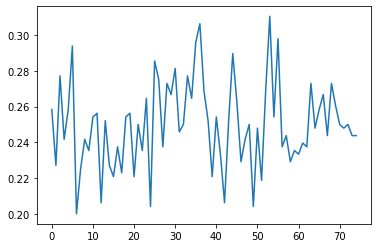

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=76
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #76 
mask dimensions: (94, 94, 72)
number of voxels in mask: 184
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 184) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 184) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 184) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 184) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 184) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 184) shape of mask (94, 94, 72)
Runs shape (6, 80, 184)
(6, 80, 184)
shape of data: (6, 80, 184)
(6, 80, 184)
results of classifier: 0.20208333333333336, type: <class 'numpy.float64'>
total time: 15.688842058181763, searchlight time: 0.2535085678100586


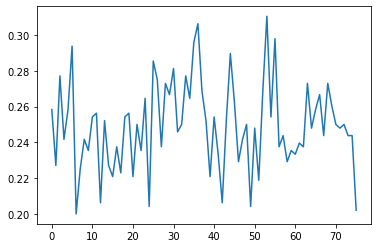

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=77
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #77 
mask dimensions: (94, 94, 72)
number of voxels in mask: 152
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 152) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 152) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 152) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 152) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 152) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 152) shape of mask (94, 94, 72)
Runs shape (6, 80, 152)
(6, 80, 152)
shape of data: (6, 80, 152)
(6, 80, 152)
results of classifier: 0.21666666666666667, type: <class 'numpy.float64'>
total time: 15.67976427078247, searchlight time: 0.18756365776062012


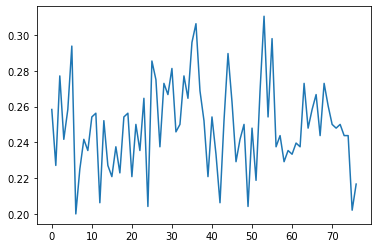

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=78
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #78 
mask dimensions: (94, 94, 72)
number of voxels in mask: 130
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 130) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 130) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 130) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 130) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 130) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 130) shape of mask (94, 94, 72)
Runs shape (6, 80, 130)
(6, 80, 130)
shape of data: (6, 80, 130)
(6, 80, 130)
results of classifier: 0.2770833333333333, type: <class 'numpy.float64'>
total time: 15.472017765045166, searchlight time: 0.13130736351013184


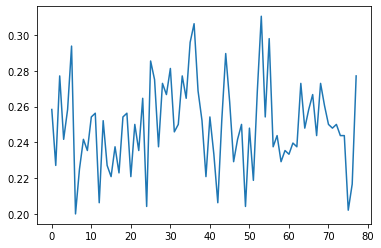

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=79
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #79 
mask dimensions: (94, 94, 72)
number of voxels in mask: 208
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 208) shape of mask (94, 94, 72)
Runs shape (6, 80, 208)
(6, 80, 208)
shape of data: (6, 80, 208)
(6, 80, 208)
results of classifier: 0.25, type: <class 'numpy.float64'>
total time: 15.769341945648193, searchlight time: 0.25689268112182617


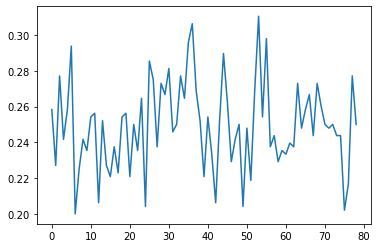

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=80
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #80 
mask dimensions: (94, 94, 72)
number of voxels in mask: 426
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 426) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 426) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 426) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 426) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 426) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 426) shape of mask (94, 94, 72)
Runs shape (6, 80, 426)
(6, 80, 426)
shape of data: (6, 80, 426)
(6, 80, 426)
results of classifier: 0.2354166666666667, type: <class 'numpy.float64'>
total time: 16.53756856918335, searchlight time: 0.3355584144592285


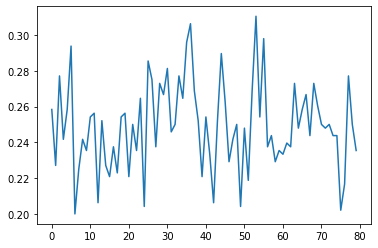

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=81
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #81 
mask dimensions: (94, 94, 72)
number of voxels in mask: 658
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 658) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 658) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 658) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 658) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 658) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 658) shape of mask (94, 94, 72)
Runs shape (6, 80, 658)
(6, 80, 658)
shape of data: (6, 80, 658)
(6, 80, 658)
results of classifier: 0.23750000000000002, type: <class 'numpy.float64'>
total time: 15.807703971862793, searchlight time: 0.33896899223327637


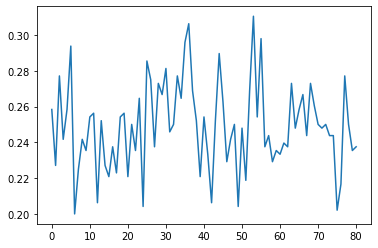

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=82
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #82 
mask dimensions: (94, 94, 72)
number of voxels in mask: 550
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 550) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 550) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 550) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 550) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 550) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 550) shape of mask (94, 94, 72)
Runs shape (6, 80, 550)
(6, 80, 550)
shape of data: (6, 80, 550)
(6, 80, 550)
results of classifier: 0.2729166666666667, type: <class 'numpy.float64'>
total time: 15.739703893661499, searchlight time: 0.3578824996948242


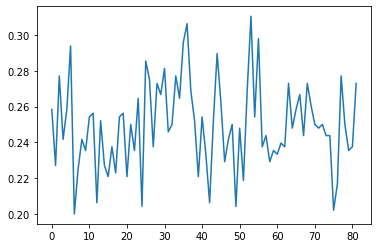

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=83
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #83 
mask dimensions: (94, 94, 72)
number of voxels in mask: 349
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 349) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 349) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 349) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 349) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 349) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 349) shape of mask (94, 94, 72)
Runs shape (6, 80, 349)
(6, 80, 349)
shape of data: (6, 80, 349)
(6, 80, 349)
results of classifier: 0.26458333333333334, type: <class 'numpy.float64'>
total time: 15.66073203086853, searchlight time: 0.2178950309753418


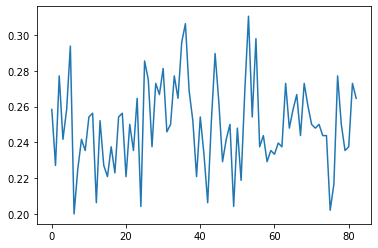

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=84
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #84 
mask dimensions: (94, 94, 72)
number of voxels in mask: 217
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 217) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 217) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 217) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 217) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 217) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 217) shape of mask (94, 94, 72)
Runs shape (6, 80, 217)
(6, 80, 217)
shape of data: (6, 80, 217)
(6, 80, 217)
results of classifier: 0.23124999999999998, type: <class 'numpy.float64'>
total time: 15.93033504486084, searchlight time: 0.2965672016143799


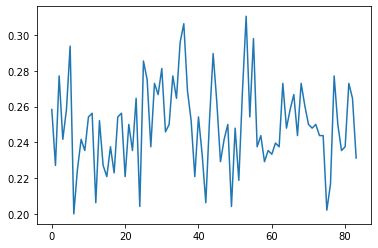

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=85
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #85 
mask dimensions: (94, 94, 72)
number of voxels in mask: 192
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 192) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 192) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 192) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 192) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 192) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 192) shape of mask (94, 94, 72)
Runs shape (6, 80, 192)
(6, 80, 192)
shape of data: (6, 80, 192)
(6, 80, 192)
results of classifier: 0.25, type: <class 'numpy.float64'>
total time: 15.9990074634552, searchlight time: 0.5640804767608643


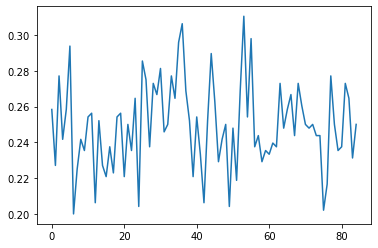

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=86
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #86 
mask dimensions: (94, 94, 72)
number of voxels in mask: 367
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
Runs shape (6, 80, 367)
(6, 80, 367)
shape of data: (6, 80, 367)
(6, 80, 367)
results of classifier: 0.23750000000000002, type: <class 'numpy.float64'>
total time: 15.57846450805664, searchlight time: 0.22101044654846191


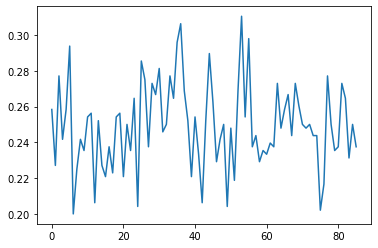

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=87
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #87 
mask dimensions: (94, 94, 72)
number of voxels in mask: 456
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 456) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 456) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 456) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 456) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 456) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 456) shape of mask (94, 94, 72)
Runs shape (6, 80, 456)
(6, 80, 456)
shape of data: (6, 80, 456)
(6, 80, 456)
results of classifier: 0.2541666666666667, type: <class 'numpy.float64'>
total time: 16.008959531784058, searchlight time: 0.4668543338775635


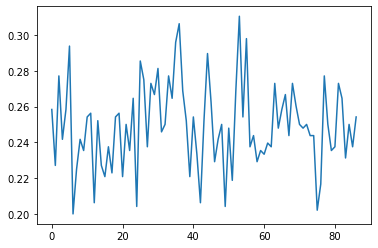

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=88
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #88 
mask dimensions: (94, 94, 72)
number of voxels in mask: 447
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 447) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 447) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 447) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 447) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 447) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 447) shape of mask (94, 94, 72)
Runs shape (6, 80, 447)
(6, 80, 447)
shape of data: (6, 80, 447)
(6, 80, 447)
results of classifier: 0.2604166666666667, type: <class 'numpy.float64'>
total time: 16.107957363128662, searchlight time: 0.3451070785522461


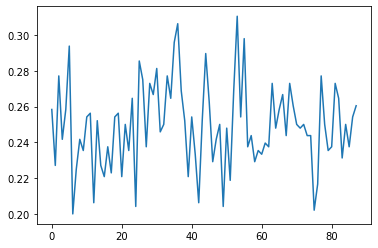

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=89
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #89 
mask dimensions: (94, 94, 72)
number of voxels in mask: 480
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 480) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 480) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 480) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 480) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 480) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 480) shape of mask (94, 94, 72)
Runs shape (6, 80, 480)
(6, 80, 480)
shape of data: (6, 80, 480)
(6, 80, 480)
results of classifier: 0.28750000000000003, type: <class 'numpy.float64'>
total time: 15.74904203414917, searchlight time: 0.1884441375732422


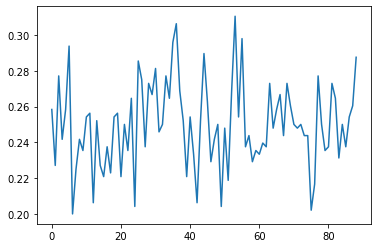

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=90
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #90 
mask dimensions: (94, 94, 72)
number of voxels in mask: 490
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 490) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 490) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 490) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 490) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 490) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 490) shape of mask (94, 94, 72)
Runs shape (6, 80, 490)
(6, 80, 490)
shape of data: (6, 80, 490)
(6, 80, 490)
results of classifier: 0.29791666666666666, type: <class 'numpy.float64'>
total time: 15.816050291061401, searchlight time: 0.22121357917785645


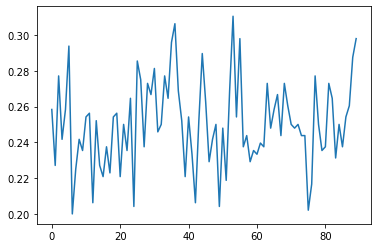

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=91
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #91 
mask dimensions: (94, 94, 72)
number of voxels in mask: 367
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 367) shape of mask (94, 94, 72)
Runs shape (6, 80, 367)
(6, 80, 367)
shape of data: (6, 80, 367)
(6, 80, 367)
results of classifier: 0.2354166666666667, type: <class 'numpy.float64'>
total time: 15.523349046707153, searchlight time: 0.2008056640625


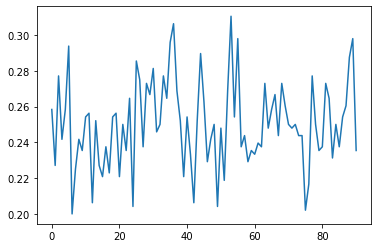

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=92
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #92 
mask dimensions: (94, 94, 72)
number of voxels in mask: 388
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 388) shape of mask (94, 94, 72)
Runs shape (6, 80, 388)
(6, 80, 388)
shape of data: (6, 80, 388)
(6, 80, 388)
results of classifier: 0.25416666666666665, type: <class 'numpy.float64'>
total time: 16.18179702758789, searchlight time: 0.22041964530944824


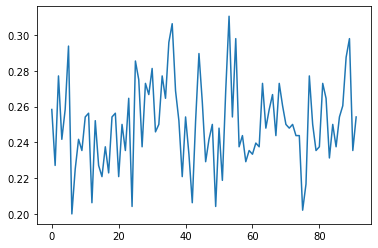

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=93
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #93 
mask dimensions: (94, 94, 72)
number of voxels in mask: 644
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 644) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 644) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 644) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 644) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 644) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 644) shape of mask (94, 94, 72)
Runs shape (6, 80, 644)
(6, 80, 644)
shape of data: (6, 80, 644)
(6, 80, 644)
results of classifier: 0.19999999999999998, type: <class 'numpy.float64'>
total time: 16.01786231994629, searchlight time: 0.2590291500091553


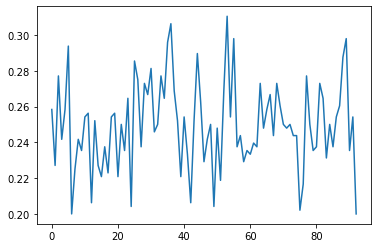

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=94
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #94 
mask dimensions: (94, 94, 72)
number of voxels in mask: 180
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 180) shape of mask (94, 94, 72)
Runs shape (6, 80, 180)
(6, 80, 180)
shape of data: (6, 80, 180)
(6, 80, 180)
results of classifier: 0.22083333333333333, type: <class 'numpy.float64'>
total time: 15.716286182403564, searchlight time: 0.22873878479003906


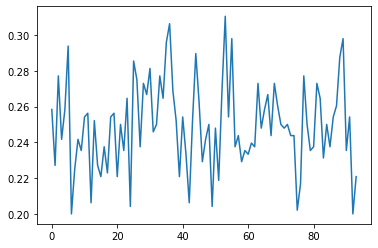

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=95
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #95 
mask dimensions: (94, 94, 72)
number of voxels in mask: 228
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 228) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 228) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 228) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 228) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 228) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 228) shape of mask (94, 94, 72)
Runs shape (6, 80, 228)
(6, 80, 228)
shape of data: (6, 80, 228)
(6, 80, 228)
results of classifier: 0.23124999999999998, type: <class 'numpy.float64'>
total time: 16.54368305206299, searchlight time: 0.26436424255371094


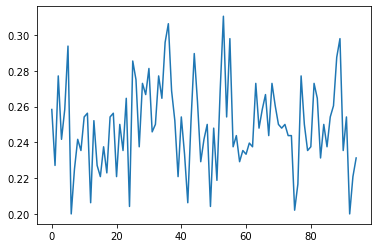

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=96
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #96 
mask dimensions: (94, 94, 72)
number of voxels in mask: 294
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 294) shape of mask (94, 94, 72)
Runs shape (6, 80, 294)
(6, 80, 294)
shape of data: (6, 80, 294)
(6, 80, 294)
results of classifier: 0.22916666666666666, type: <class 'numpy.float64'>
total time: 15.8380606174469, searchlight time: 0.34752321243286133


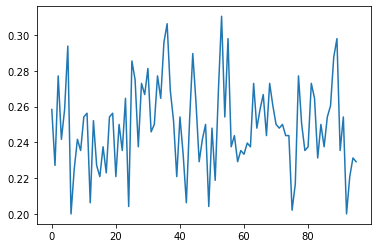

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=97
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #97 
mask dimensions: (94, 94, 72)
number of voxels in mask: 270
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 270) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 270) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 270) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 270) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 270) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 270) shape of mask (94, 94, 72)
Runs shape (6, 80, 270)
(6, 80, 270)
shape of data: (6, 80, 270)
(6, 80, 270)
results of classifier: 0.2395833333333333, type: <class 'numpy.float64'>
total time: 15.901766061782837, searchlight time: 0.355029821395874


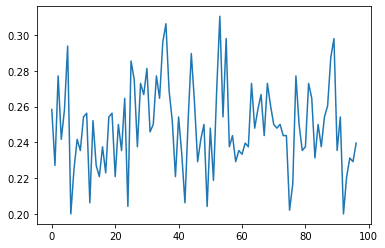

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=98
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #98 
mask dimensions: (94, 94, 72)
number of voxels in mask: 128
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 128) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 128) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 128) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 128) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 128) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 128) shape of mask (94, 94, 72)
Runs shape (6, 80, 128)
(6, 80, 128)
shape of data: (6, 80, 128)
(6, 80, 128)
results of classifier: 0.21875, type: <class 'numpy.float64'>
total time: 15.670654058456421, searchlight time: 0.15523123741149902


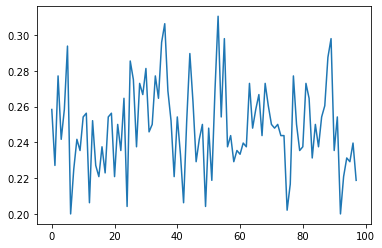

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=99
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #99 
mask dimensions: (94, 94, 72)
number of voxels in mask: 253
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 253) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 253) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 253) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 253) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 253) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 253) shape of mask (94, 94, 72)
Runs shape (6, 80, 253)
(6, 80, 253)
shape of data: (6, 80, 253)
(6, 80, 253)
results of classifier: 0.21041666666666667, type: <class 'numpy.float64'>
total time: 15.846888303756714, searchlight time: 0.3905014991760254


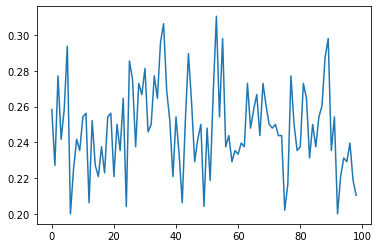

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=100
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #100 
mask dimensions: (94, 94, 72)
number of voxels in mask: 393
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 393) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 393) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 393) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 393) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 393) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 393) shape of mask (94, 94, 72)
Runs shape (6, 80, 393)
(6, 80, 393)
shape of data: (6, 80, 393)
(6, 80, 393)
results of classifier: 0.275, type: <class 'numpy.float64'>
total time: 15.594286680221558, searchlight time: 0.23933672904968262


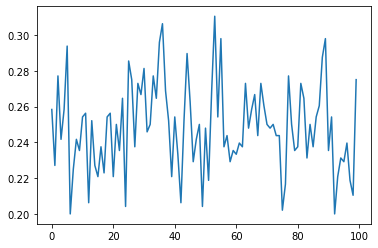

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=101
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #101 
mask dimensions: (94, 94, 72)
number of voxels in mask: 315
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 315) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 315) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 315) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 315) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 315) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 315) shape of mask (94, 94, 72)
Runs shape (6, 80, 315)
(6, 80, 315)
shape of data: (6, 80, 315)
(6, 80, 315)
results of classifier: 0.22708333333333333, type: <class 'numpy.float64'>
total time: 15.94582986831665, searchlight time: 0.30165529251098633


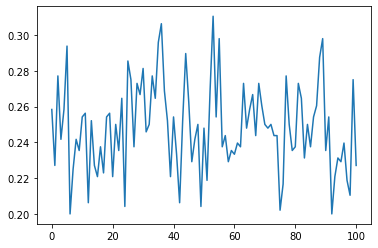

Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=102
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #102 
mask dimensions: (94, 94, 72)
number of voxels in mask: 434
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 434) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 434) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 434) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 434) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 434) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [ ]:
def loop(roinum):
    '''
    from the main directory, run batchRegions.sh, it will run the script classRegion.sh, which is just a feeder for classRegion.py for all ROI/parcels across both wang and schaefer.

    classRegion.py simply runs a runwise cross-validated classifier across the runs of recognition data, then stores the average accuracy of the ROI it was assigned in an numpy array. 
    This is stored within the subject specific folder (e.g. wang2014/0111171/output/roi25_rh.npy )

    input:
        1 subject: which subject
        2 dataloc: neurosketch or realtime
        3 roiloc: schaefer2018 or wang2014
        4 roinum: number of rois you want
        5 roihemi: which hemisphere

    '''
    import nibabel as nib
    import numpy as np
    import os
    import sys
    import time
    import pandas as pd
    from sklearn.linear_model import LogisticRegression

    # Running subject 0119173, with neurosketch as a data source, wang2014 roi #roi14 _rh
    # What subject are you running
    subject = "0119173"

    try:
        roiloc = "schaefer2018"
        print("Using user-selected roi location: {}".format(roiloc))
    except:
        print("NO ROI LOCATION ENTERED: Using radius of wang2014")
        roiloc = "wang2014"

    try:
        dataSource = "neurosketch"  # could be neurosketch or realtime
        print("Using {} data".format(dataSource))
    except:
        print("NO DATASOURCE ENTERED: Using original neurosketch data")
        dataSource = 'neurosketch'

#     try:
#         roinum = str(roinum) if roiloc == "schaefer2018" else "roi{}".format(str(sys.argv[4])) 
#         print("running for roi #{} in {}".format(str(sys.argv[4]), roiloc))
#     except:
#         print("NO ROI SPECIFIED: Using roi number 1")
#         roinum="1"
    roinum = str(roinum) 
    print(f"roinum={roinum}")
    if roiloc == "wang2014":
        try:
            roihemi = "_{}".format(str(sys.argv[5]))
            print("Since this is wang2014, we need a hemisphere, in this case {}".format(str(sys.argv[5])))
        except:
            print("this is wang 2014, so we need a hemisphere, but one was not specified")
            assert 1 == 2
    else:
        roihemi=""

    print("Running subject {}, with {} as a data source, {} roi #{} {}".format(subject, dataSource, roiloc, roinum, roihemi))

    workDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    # dataSource depending, there are a number of keywords to fill in: 
    # ses: which day of data collection
    # run: which run number on that day (single digit)
    # phase: 12, 34, or 56
    # sub: subject number
    if dataSource == "neurosketch":
        funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
    elif dataSource == "realtime":
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
        anat = "$TO_BE_FILLED"
    else:
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "$TO_BE_FILLED"

    outloc = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout"
    starttime = time.time()

    def Wait(waitfor, delay=1):
        while not os.path.exists(waitfor):
            time.sleep(delay)
            print('waiting for {}'.format(waitfor))

    def normalize(X):
        from scipy.stats import zscore
        # X = X - X.mean(0)
        X = zscore(X, axis=0)
        X[np.isnan(X)]=0
        return X


    def Class(data, bcvar):
        metas = bcvar[0]
        data4d = data[0]
        print(data4d.shape)

        accs = []
        for run in range(6):
            testX = data4d[run]
            testY = metas[run]
            trainX = data4d[np.arange(6) != run]
            trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
            trainY = []
            for meta in range(6):
                if meta != run:
                    trainY.extend(metas[meta])
            clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                     multi_class='multinomial').fit(trainX, trainY)

            # Monitor progress by printing accuracy (only useful if you're running a test set)
            acc = clf.score(testX, testY)
            accs.append(acc)

        return np.mean(accs)


    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}

    mask = nib.load(workDir+"{}/{}/{}{}.nii.gz".format(roiloc, subject, roinum, roihemi)).get_data()
    mask = mask.astype(int)
    # say some things about the mask.
    print('mask dimensions: {}'. format(mask.shape))
    print('number of voxels in mask: {}'.format(np.sum(mask)))


    # Compile preprocessed data and corresponding indices
    metas = []

    for run in range(1, 7):
        print(run, end='--')
        # retrieve from the dictionary which phase it is, assign the session
        phase = phasedict[run]
        ses = 1

        # Build the path for the preprocessed functional data
        this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)

        # Read in the metadata, and reduce it to only the TR values from this run, add to a list
        thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
        if dataSource == "neurosketch":
            _run = 1 if run % 2 == 0 else 2
        else:
            _run = run
        thismeta = thismeta[thismeta['run_num'] == int(_run)]

        if dataSource == "realtime":
            TR_num = list(thismeta.TR.astype(int))
            labels = list(thismeta.Item)
            labels = [imcodeDict[label] for label in labels]
        else:
            TR_num = list(thismeta.TR_num.astype(int))
            labels = list(thismeta.label)

        print("LENGTH OF TR: {}".format(len(TR_num)))
        # Load the functional data
        runIm = nib.load(this4d)
        affine_mat = runIm.affine
        runImDat = runIm.get_data()

        # Use the TR numbers to select the correct features
        features = [runImDat[:,:,:,n+3] for n in TR_num] #axis0 is time/repetition
        features = np.array(features)
        features = features[:, mask==1]
        print("shape of features", features.shape, "shape of mask", mask.shape)
        # featmean = features.mean(1)[..., None] # equivalent to featmean = np.mean(features,axis=1).reshape(-1,1)
        # features = features - features.mean(0)
        features = normalize(features)
        features = np.expand_dims(features, 0)

        # Append both so we can use it later
        metas.append(labels)
        runs = features if run == 1 else np.concatenate((runs, features))

    dimsize = runIm.header.get_zooms()

    data = []
    # Preset the variables
    print("Runs shape", runs.shape)
    _data = runs
    print(_data.shape)
    data.append(_data)
    print("shape of data: {}".format(_data.shape))

    bcvar = [metas]

    # Distribute the information to the searchlights (preparing it to run)
    slstart = time.time()
    sl_result = Class(data, bcvar)
    print("results of classifier: {}, type: {}".format(sl_result, type(sl_result)))

    SL = time.time() - slstart
    tot = time.time() - starttime
    print('total time: {}, searchlight time: {}'.format(tot, SL))

    # outfile = workDir+"{}/{}/output/tag2_{}{}.npy".format(roiloc, subject, roinum, roihemi)
    # print(outfile)
    # np.save(outfile, np.array(sl_result))
    return sl_result
reusts=[]
for i in range(1,301):
    t= loop(i)
    reusts.append(t)
    plt.plot(reusts)
    plt.show()

In [2]:



import os
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
import subprocess
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib,pickle
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# from rtCommon.fileClient import FileInterface
# import rtCommon.projectUtils as projUtils
# from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti


# argParser = argparse.ArgumentParser()
# argParser.add_argument('--config', '-c', default='sub001.ses1.toml', type=str, help='experiment file (.json or .toml)')
# args = argParser.parse_args()
from rtCommon.cfg_loading import mkdir,cfg_loading
config="sub001.ses2.toml"
cfg = cfg_loading(config)

sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/')
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading



/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  if __name__ == '__main__':


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub001.ses2.toml


In [112]:
clf.predict_proba(X)

array([[0.44382823, 0.55617177],
       [0.44382823, 0.55617177],
       [0.44382823, 0.55617177],
       [0.44382823, 0.55617177],
       [0.44382823, 0.55617177],
       [0.44382823, 0.55617177],
       [0.44382823, 0.55617177],
       [0.44382823, 0.55617177],
       [0.44382823, 0.55617177],
       [0.44382823, 0.55617177]])

In [86]:
config="sub001.ses2.toml"
cfg = cfg_loading(config)
def classifierEvidence(clf,X,Y): # X shape is [trials,voxelNumber], Y is ['bed', 'bed'] for example # return a 1-d array of probability
    # This function get the data X and evidence object I want to know Y, and output the trained model evidence.
    targetID=[np.where((clf.classes_==i)==True)[0][0] for i in Y]
    Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
    return np.asarray(Evidence)
X=np.zeros((1, 324))
Y = ['table'] * X.shape[0]
CD_clf=joblib.load(cfg.usingModel_dir +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
CD_C_evidence = classifierEvidence(CD_clf,X,Y)

toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub001.ses2.toml


In [3]:

config="sub001.ses1.toml"
cfg = cfg_loading(config)
accs = minimalClass(cfg)
# [mu,sig]=np.load(f"{cfg.feedback_dir}morphingTarget.npy")
# print(f"mu={mu},sig={sig}")
accs

toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub001.ses1.toml


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


FEAT.shape=(378, 324)
obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']
bedbench_bedchair 0.75
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']
bedbench_bedtable 0.4166666666666667
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedbench_benchchair 0.4782608695652174
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
bedbench_benchtable 0.7391304347826086
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']
bedchair_bedbench 0.8695652173913043
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']
bedchair_bedtable 0.4166666666666667
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedchair_chairbench 0.4782608695652174
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
bedchair_chairtable 0.8333333333333334
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']
bedtable_bedbench 0.8695652173913043
obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']
bedtable_bedchair 0.75
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
bedtable_tablebench 0.7391304347826086
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
bedtable_tablechair 0.8333333333333334


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']
benchchair_benchbed 0.8695652173913043
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
benchchair_benchtable 0.7391304347826086
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']
benchchair_chairbed 0.75
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
benchchair_chairtable 0.8333333333333334
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']
benchtable_benchbed 0.8695652173913043
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']
benchtable_benchchair 0.4782608695652174
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']
benchtable_tablebed 0.4166666666666667
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
benchtable_tablechair 0.8333333333333334
obj=chair,alto

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

chairtable_tablebed 0.4166666666666667
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
chairtable_tablebench 0.7391304347826086


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

{'bedbench_bedchair': 0.75,
 'bedbench_bedtable': 0.4166666666666667,
 'bedbench_benchchair': 0.4782608695652174,
 'bedbench_benchtable': 0.7391304347826086,
 'bedchair_bedbench': 0.8695652173913043,
 'bedchair_bedtable': 0.4166666666666667,
 'bedchair_chairbench': 0.4782608695652174,
 'bedchair_chairtable': 0.8333333333333334,
 'bedtable_bedbench': 0.8695652173913043,
 'bedtable_bedchair': 0.75,
 'bedtable_tablebench': 0.7391304347826086,
 'bedtable_tablechair': 0.8333333333333334,
 'benchchair_benchbed': 0.8695652173913043,
 'benchchair_benchtable': 0.7391304347826086,
 'benchchair_chairbed': 0.75,
 'benchchair_chairtable': 0.8333333333333334,
 'benchtable_benchbed': 0.8695652173913043,
 'benchtable_benchchair': 0.4782608695652174,
 'benchtable_tablebed': 0.4166666666666667,
 'benchtable_tablechair': 0.8333333333333334,
 'chairtable_chairbed': 0.75,
 'chairtable_chairbench': 0.4782608695652174,
 'chairtable_tablebed': 0.4166666666666667,
 'chairtable_tablebench': 0.7391304347826086}

In [54]:
from scipy.stats import zscore

def gaussian(x, mu, sig):
    # mu and sig is determined before each neurofeedback session using 2 recognition runs.
    return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

a=np.zeros((3,3))

b=np.array([[0., 0., 1],
       [1, 0., 0.],
       [0., 1, 0.]])
c=a[b==1]
c=np.expand_dims(c, axis=0)
c.shape
c=normalize(c)
c

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


array([[nan, nan, nan]])

toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub001.ses2.toml
mu=-0.5264861229479428,sig=0.061295746671419384


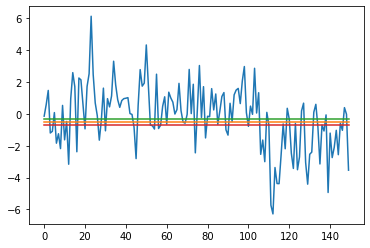

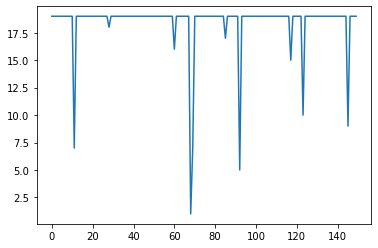

In [149]:
def monitor(scnNum,config="sub001.ses3.toml"):
    cfg = cfg_loading(config)
    [mu,sig]=np.load(f"{cfg.feedback_dir}morphingTarget.npy")
#     sig=0.5
    B_evidences = np.load(f'{cfg.feedback_dir}B_evidences_{scnNum}.npy')
    plt.plot(B_evidences)
    plt.plot(np.arange(0,150),150*[mu])
    plt.plot(np.arange(0,150),150*[mu+3*sig])
    plt.plot(np.arange(0,150),150*[mu-3*sig])
    print(f"mu={mu},sig={sig}")

    _=plt.figure()
    morphParam=[int(gaussian(B_evidence, mu, sig)) for B_evidence in B_evidences]
    plt.plot(morphParam)
monitor(2,config="sub001.ses2.toml")

In [37]:
# 2*mu = ceil+floor
# 2.3548*sig = ceil-floor

ceil=(2*mu+2.3548*sig)/2
floor=(2*mu-2.3548*sig)/2
print(f"ceil={ceil} floor={floor}")

ceil=0.7190021008255804 floor=0.5986557350788723


In [4]:
a=np.random.rand(4,3)
from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X
a=normalize(a)
a

array([[ 1.18903134,  0.43192296,  1.00509673],
       [-0.15858567,  0.12351643,  0.88974841],
       [-1.52273113, -1.62752149, -0.49858558],
       [ 0.49228546,  1.0720821 , -1.39625956]])